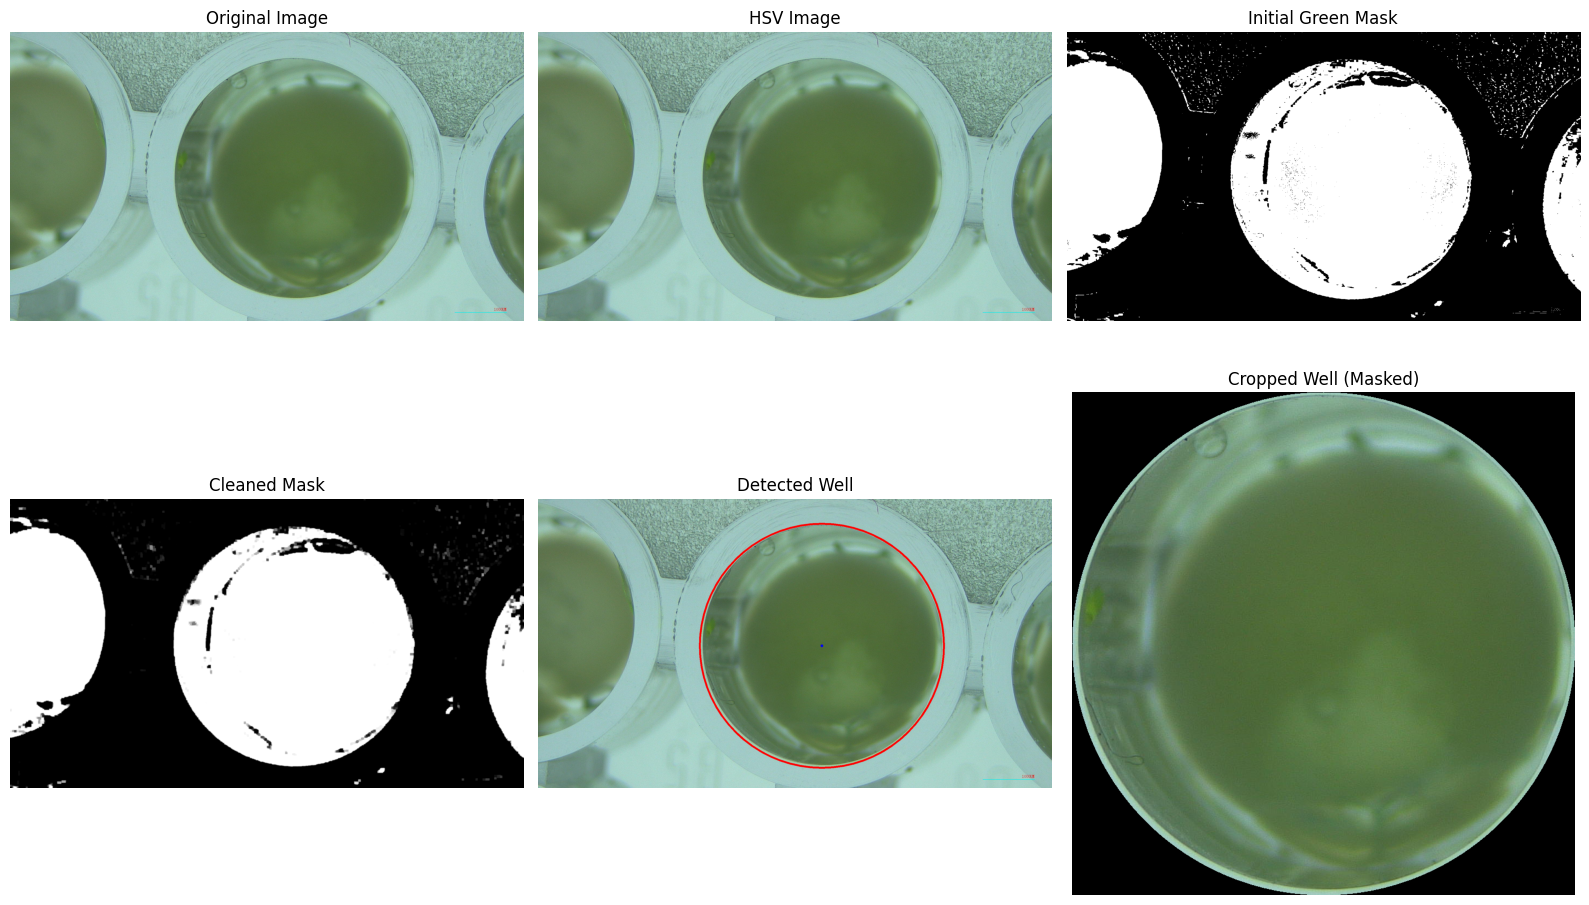

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Path to your image
image_path = "New MLPR Data/30 hr/pH5 Hydrolytic/30hr_pH5_W5.JPG" 

# Define green color range in HSV
lower_green = np.array([20, 20, 100])
upper_green = np.array([70, 255, 255])

# Load the image
image = cv2.imread(image_path)
if image is None:
    print(f"❌ Error loading image: {image_path}")
    exit()

# Convert to HSV and apply mask
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
initial_mask = cv2.inRange(hsv, lower_green, upper_green)

# Apply Gaussian Blur to smooth edges
blurred_mask = cv2.GaussianBlur(initial_mask, (5, 5), 0)

# Morphological operations to clean up the mask
kernel = np.ones((7, 7), np.uint8)
clean_mask = cv2.morphologyEx(blurred_mask, cv2.MORPH_CLOSE, kernel)
clean_mask = cv2.morphologyEx(clean_mask, cv2.MORPH_OPEN, kernel)

# Find contours
contours, _ = cv2.findContours(clean_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
well_contour = None
max_radius = 0

# Identify the largest reasonably circular contour
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area < 5000:
        continue

    (x, y), radius = cv2.minEnclosingCircle(cnt)
    circularity = (4 * np.pi * area) / (cv2.arcLength(cnt, True) ** 2 + 1e-5)
    
    if radius > max_radius and radius > 30 and circularity > 0.6:
        max_radius = radius
        well_contour = (int(x), int(y), int(radius))

# Draw and crop the well
output = image.copy()
cropped_result = None

if well_contour:
    x, y, r = well_contour
    cv2.circle(output, (x, y), r, (0, 0, 255), 5)
    cv2.circle(output, (x, y), 5, (255, 0, 0), -1)

    h, w = image.shape[:2]
    x1, y1 = max(x - r, 0), max(y - r, 0)
    x2, y2 = min(x + r, w), min(y + r, h)

    cropped_image = image[y1:y2, x1:x2]
    
    if cropped_image.size > 0:
        h_c, w_c = cropped_image.shape[:2]
        circular_mask = np.zeros((h_c, w_c), dtype=np.uint8)
        cv2.circle(circular_mask, (w_c // 2, h_c // 2), min(r, w_c // 2, h_c // 2), 255, -1)
        cropped_result = cv2.bitwise_and(cropped_image, cropped_image, mask=circular_mask)

# Convert images to RGB for matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
output_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
hsv_rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
if cropped_result is not None:
    cropped_rgb = cv2.cvtColor(cropped_result, cv2.COLOR_BGR2RGB)

# Plot the results
plt.figure(figsize=(16, 10))

plt.subplot(2, 3, 1)
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(hsv_rgb)
plt.title("HSV Image")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(initial_mask, cmap='gray')
plt.title("Initial Green Mask")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(clean_mask, cmap='gray')
plt.title("Cleaned Mask")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(output_rgb)
plt.title("Detected Well")
plt.axis('off')

if cropped_result is not None:
    plt.subplot(2, 3, 6)
    plt.imshow(cropped_rgb)
    plt.title("Cropped Well (Masked)")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [1]:
import cv2
import numpy as np
import os

# Root folders
dataset_root = "New MLPR Data"
output_root = "New_Processed_Images"
cropped_output_root = "New_Cropped_Images"

# Create root output folders if not already present
os.makedirs(output_root, exist_ok=True)
os.makedirs(cropped_output_root, exist_ok=True)

# Define green color range in HSV
lower_green = np.array([20, 20, 100])
upper_green = np.array([70, 255, 255])

# Kernel for morphology
kernel = np.ones((7, 7), np.uint8)

def process_images_in_folder(folder_path, output_folder, cropped_folder):
    os.makedirs(output_folder, exist_ok=True)
    os.makedirs(cropped_folder, exist_ok=True)

    for item in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item)
        output_item_path = os.path.join(output_folder, item)
        cropped_item_path = os.path.join(cropped_folder, item)

        if os.path.isdir(item_path):
            process_images_in_folder(item_path, output_item_path, cropped_item_path)

        elif item.lower().endswith(('.png', '.jpg', '.jpeg')):
            image = cv2.imread(item_path)
            if image is None:
                print(f"❌ Error loading image: {item_path}")
                continue

            # Preprocessing
            hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            mask = cv2.inRange(hsv, lower_green, upper_green)
            mask = cv2.GaussianBlur(mask, (5, 5), 0)
            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            well_contour = None
            max_radius = 0

            for cnt in contours:
                area = cv2.contourArea(cnt)
                if area < 5000:
                    continue  # ignore small regions

                (x, y), radius = cv2.minEnclosingCircle(cnt)
                circularity = (4 * np.pi * area) / (cv2.arcLength(cnt, True) ** 2 + 1e-5)

                if radius > max_radius and radius > 30 and circularity > 0.6:
                    max_radius = radius
                    well_contour = (int(x), int(y), int(radius))

            output = image.copy()

            if well_contour:
                x, y, r = well_contour
                cv2.circle(output, (x, y), r, (0, 0, 255), 5)
                cv2.circle(output, (x, y), 5, (255, 0, 0), -1)

                h, w = image.shape[:2]
                x1, y1 = max(x - r, 0), max(y - r, 0)
                x2, y2 = min(x + r, w), min(y + r, h)

                cropped_image = image[y1:y2, x1:x2]

                if cropped_image.size > 0:
                    h_c, w_c = cropped_image.shape[:2]
                    circular_mask = np.zeros((h_c, w_c), dtype=np.uint8)
                    cv2.circle(circular_mask, (w_c // 2, h_c // 2), min(r, w_c // 2, h_c // 2), 255, -1)
                    cropped_result = cv2.bitwise_and(cropped_image, cropped_image, mask=circular_mask)

                    cropped_filename = os.path.join(cropped_folder, f"cropped_{item}")
                    cv2.imwrite(cropped_filename, cropped_result)
                    print(f"✅ Cropped saved: {cropped_filename}")
                else:
                    print(f"⚠️ Skipping crop for {item}: Invalid crop size")

            # Save output and mask
            cv2.imwrite(os.path.join(output_folder, f"processed_{item}"), output)
            cv2.imwrite(os.path.join(output_folder, f"mask_{item}"), mask)

# Start processing entire dataset
process_images_in_folder(dataset_root, output_root, cropped_output_root)

print("✅ All images processed and saved.")


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/192 hr/pH6 Hydrolytic/cropped_192hr_pH6_W32.JPG
✅ Cropped saved: New_Cropped_Images/192 hr/pH6 Hydrolytic/cropped_192hr_pH6_W43.JPG
✅ Cropped saved: New_Cropped_Images/192 hr/pH6 Hydrolytic/cropped_192hr_pH6_W42.JPG


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/192 hr/pH6 Hydrolytic/cropped_192hr_pH6_W46.JPG


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/192 hr/pH5 Hydrolytic/cropped_192hr_pH5_W40.JPG
✅ Cropped saved: New_Cropped_Images/192 hr/pH5 Hydrolytic/cropped_192hr_pH5_W43.JPG
✅ Cropped saved: New_Cropped_Images/192 hr/pH5 Hydrolytic/cropped_192hr_pH5_W42.JPG


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/192 hr/pH8 Hydrolytic/cropped_192hr_pH8_W36.JPG
✅ Cropped saved: New_Cropped_Images/192 hr/pH8 Hydrolytic/cropped_192hr_pH8_W33.JPG
✅ Cropped saved: New_Cropped_Images/192 hr/pH8 Hydrolytic/cropped_192hr_pH8_W27.JPG
✅ Cropped saved: New_Cropped_Images/192 hr/pH8 Hydrolytic/cropped_192hr_pH8_W26.JPG
✅ Cropped saved: New_Cropped_Images/192 hr/pH8 Hydrolytic/cropped_192hr_pH8_W18.JPG


Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/192 hr/pH8 Hydrolytic/cropped_192hr_pH8_W19.JPG
✅ Cropped saved: New_Cropped_Images/192 hr/pH8 Hydrolytic/cropped_192hr_pH8_W42.JPG
✅ Cropped saved: New_Cropped_Images/192 hr/pH8 Hydrolytic/cropped_192hr_pH8_W40.JPG
✅ Cropped saved: New_Cropped_Images/192 hr/pH8 Hydrolytic/cropped_192hr_pH8_W4.JPG
✅ Cropped saved: New_Cropped_Images/192 hr/pH8 Hydrolytic/cropped_192hr_pH8_W44.JPG
✅ Cropped saved: New_Cropped_Images/192 hr/pH8 Hydrolytic/cropped_192hr_pH8_W47.JPG


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/192 hr/pH8 Hydrolytic/cropped_192hr_pH8_W46.JPG
✅ Cropped saved: New_Cropped_Images/192 hr/pH8 Hydrolytic/cropped_192hr_pH8_W48.JPG
✅ Cropped saved: New_Cropped_Images/192 hr/pH8 Hydrolytic/cropped_192hr_pH8_W14.JPG
✅ Cropped saved: New_Cropped_Images/192 hr/pH8 Hydrolytic/cropped_192hr_pH8_W29.JPG
✅ Cropped saved: New_Cropped_Images/192 hr/pH8 Hydrolytic/cropped_192hr_pH8_W16.JPG
✅ Cropped saved: New_Cropped_Images/192 hr/pH8 Hydrolytic/cropped_192hr_pH8_W13.JPG
✅ Cropped saved: New_Cropped_Images/192 hr/pH8 Hydrolytic/cropped_192hr_pH8_W39.JPG


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/192 hr/pH8 Hydrolytic/cropped_192hr_pH8_W10.JPG
✅ Cropped saved: New_Cropped_Images/192 hr/pH7 Hydrolytic/cropped_192hr_pH7_W8.JPG
✅ Cropped saved: New_Cropped_Images/192 hr/pH7 Hydrolytic/cropped_192hr_pH7_W39.JPG
✅ Cropped saved: New_Cropped_Images/192 hr/pH7 Hydrolytic/cropped_192hr_pH7_W16.JPG


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/192 hr/pH7 Hydrolytic/cropped_192hr_pH7_W29.JPG
✅ Cropped saved: New_Cropped_Images/192 hr/pH7 Hydrolytic/cropped_192hr_pH7_W28.JPG
✅ Cropped saved: New_Cropped_Images/192 hr/pH7 Hydrolytic/cropped_192hr_pH7_W31.JPG
✅ Cropped saved: New_Cropped_Images/192 hr/pH7 Hydrolytic/cropped_192hr_pH7_W30.JPG
✅ Cropped saved: New_Cropped_Images/192 hr/pH7 Hydrolytic/cropped_192hr_pH7_W26.JPG
✅ Cropped saved: New_Cropped_Images/192 hr/pH7 Hydrolytic/cropped_192hr_pH7_W32.JPG
✅ Cropped saved: New_Cropped_Images/192 hr/pH7 Hydrolytic/cropped_192hr_pH7_W33.JPG
✅ Cropped saved: New_Cropped_Images/192 hr/pH7 Hydrolytic/cropped_192hr_pH7_W27.JPG
✅ Cropped saved: New_Cropped_Images/192 hr/pH7 Hydrolytic/cropped_192hr_pH7_W22.JPG
✅ Cropped saved: New_Cropped_Images/192 hr/pH7 Hydrolytic/cropped_192hr_pH7_W34.JPG
✅ Cropped saved: New_Cropped_Images/192 hr/pH7 Hydrolytic/cropped_192hr_pH7_W20.JPG
✅ Cropped saved: New_Cropped_Images/192 hr/pH7 Hydrolytic/cropped_192hr_pH7_

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/192 hr/pH7 Hydrolytic/cropped_192hr_pH7_W40.JPG
✅ Cropped saved: New_Cropped_Images/192 hr/pH7 Hydrolytic/cropped_192hr_pH7_W41.JPG
✅ Cropped saved: New_Cropped_Images/192 hr/pH7 Hydrolytic/cropped_192hr_pH7_W4.JPG
✅ Cropped saved: New_Cropped_Images/192 hr/pH7 Hydrolytic/cropped_192hr_pH7_W5.JPG
✅ Cropped saved: New_Cropped_Images/192 hr/pH7 Hydrolytic/cropped_192hr_pH7_W42.JPG
✅ Cropped saved: New_Cropped_Images/120 hr/pH6 Hydrolytic/cropped_120hr_pH6_W6.JPG
✅ Cropped saved: New_Cropped_Images/120 hr/pH6 Hydrolytic/cropped_120hr_pH6_W37.JPG


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/120 hr/pH6 Hydrolytic/cropped_120hr_pH6_W3.JPG
✅ Cropped saved: New_Cropped_Images/120 hr/pH6 Hydrolytic/cropped_120hr_pH6_W47.JPG
✅ Cropped saved: New_Cropped_Images/120 hr/pH6 Hydrolytic/cropped_120hr_pH6_W46.JPG
✅ Cropped saved: New_Cropped_Images/120 hr/pH6 Hydrolytic/cropped_120hr_pH6_W44.JPG


Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/120 hr/pH5 Hydrolytic/cropped_120hr_pH5_W42.JPG
✅ Cropped saved: New_Cropped_Images/120 hr/pH5 Hydrolytic/cropped_120hr_pH5_W21.JPG
✅ Cropped saved: New_Cropped_Images/120 hr/pH5 Hydrolytic/cropped_120hr_pH5_W20.JPG


Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/120 hr/pH5 Hydrolytic/cropped_120hr_pH5_W31.JPG


Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/120 hr/pH8 Hydrolytic/cropped_120hr_pH8_W3.JPG
✅ Cropped saved: New_Cropped_Images/120 hr/pH8 Hydrolytic/cropped_120hr_pH8_W2.JPG
✅ Cropped saved: New_Cropped_Images/120 hr/pH8 Hydrolytic/cropped_120hr_pH8_W48.JPG
✅ Cropped saved: New_Cropped_Images/120 hr/pH8 Hydrolytic/cropped_120hr_pH8_W1.JPG
✅ Cropped saved: New_Cropped_Images/120 hr/pH8 Hydrolytic/cropped_120hr_pH8_W5.JPG
✅ Cropped saved: New_Cropped_Images/120 hr/pH8 Hydrolytic/cropped_120hr_pH8_W4.JPG
✅ Cropped saved: New_Cropped_Images/120 hr/pH8 Hydrolytic/cropped_120hr_pH8_W6.JPG
✅ Cropped saved: New_Cropped_Images/120 hr/pH8 Hydrolytic/cropped_120hr_pH8_W7.JPG
✅ Cropped saved: New_Cropped_Images/120 hr/pH8 Hydrolytic/cropped_120hr_pH8_W16.JPG
✅ Cropped saved: New_Cropped_Images/120 hr/pH8 Hydrolytic/cropped_120hr_pH8_W17.JPG
✅ Cropped saved: New_Cropped_Images/120 hr/pH8 Hydrolytic/cropped_120hr_pH8_W29.JPG
✅ Cropped saved: New_Cropped_Images/120 hr/pH8 Hydrolytic/cropped_120hr_pH8_W15.JPG

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/120 hr/pH8 Hydrolytic/cropped_120hr_pH8_W20.JPG
✅ Cropped saved: New_Cropped_Images/120 hr/pH8 Hydrolytic/cropped_120hr_pH8_W34.JPG
✅ Cropped saved: New_Cropped_Images/120 hr/pH8 Hydrolytic/cropped_120hr_pH8_W35.JPG
✅ Cropped saved: New_Cropped_Images/120 hr/pH8 Hydrolytic/cropped_120hr_pH8_W21.JPG
✅ Cropped saved: New_Cropped_Images/120 hr/pH8 Hydrolytic/cropped_120hr_pH8_W25.JPG
✅ Cropped saved: New_Cropped_Images/120 hr/pH8 Hydrolytic/cropped_120hr_pH8_W31.JPG
✅ Cropped saved: New_Cropped_Images/120 hr/pH8 Hydrolytic/cropped_120hr_pH8_W19.JPG
✅ Cropped saved: New_Cropped_Images/120 hr/pH8 Hydrolytic/cropped_120hr_pH8_W18.JPG
✅ Cropped saved: New_Cropped_Images/120 hr/pH8 Hydrolytic/cropped_120hr_pH8_W30.JPG
✅ Cropped saved: New_Cropped_Images/120 hr/pH8 Hydrolytic/cropped_120hr_pH8_W24.JPG
✅ Cropped saved: New_Cropped_Images/120 hr/pH8 Hydrolytic/cropped_120hr_pH8_W32.JPG
✅ Cropped saved: New_Cropped_Images/120 hr/pH8 Hydrolytic/cropped_120hr_pH8_

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/120 hr/pH7 Hydrolytic/cropped_120hr_pH7_W41.JPG
✅ Cropped saved: New_Cropped_Images/120 hr/pH7 Hydrolytic/cropped_120hr_pH7_W8.JPG
✅ Cropped saved: New_Cropped_Images/120 hr/pH7 Hydrolytic/cropped_120hr_pH7_W9.JPG
✅ Cropped saved: New_Cropped_Images/120 hr/pH7 Hydrolytic/cropped_120hr_pH7_W40.JPG
✅ Cropped saved: New_Cropped_Images/120 hr/pH7 Hydrolytic/cropped_120hr_pH7_W4.JPG
✅ Cropped saved: New_Cropped_Images/120 hr/pH7 Hydrolytic/cropped_120hr_pH7_W5.JPG
✅ Cropped saved: New_Cropped_Images/120 hr/pH7 Hydrolytic/cropped_120hr_pH7_W7.JPG
✅ Cropped saved: New_Cropped_Images/120 hr/pH7 Hydrolytic/cropped_120hr_pH7_W6.JPG
✅ Cropped saved: New_Cropped_Images/120 hr/pH7 Hydrolytic/cropped_120hr_pH7_W2.JPG
✅ Cropped saved: New_Cropped_Images/120 hr/pH7 Hydrolytic/cropped_120hr_pH7_W3.JPG
✅ Cropped saved: New_Cropped_Images/120 hr/pH7 Hydrolytic/cropped_120hr_pH7_W48.JPG
✅ Cropped saved: New_Cropped_Images/120 hr/pH7 Hydrolytic/cropped_120hr_pH7_W1.JPG
✅

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/120 hr/pH7 Hydrolytic/cropped_120hr_pH7_W16.JPG
✅ Cropped saved: New_Cropped_Images/216 hr/pH5 Hydrolytic /cropped_216hr_pH5_W43.JPG


Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/216 hr/pH6 Hydrolytic/cropped_216hr_pH6_W47.JPG
✅ Cropped saved: New_Cropped_Images/216 hr/pH6 Hydrolytic/cropped_216hr_pH6_W46.JPG
✅ Cropped saved: New_Cropped_Images/216 hr/pH6 Hydrolytic/cropped_216hr_pH6_W2.JPG
✅ Cropped saved: New_Cropped_Images/216 hr/pH6 Hydrolytic/cropped_216hr_pH6_W43.JPG


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/216 hr/pH8 Hydrolytic/cropped_216hr_pH8_W48.JPG
✅ Cropped saved: New_Cropped_Images/216 hr/pH8 Hydrolytic/cropped_216hr_pH8_W13.JPG
✅ Cropped saved: New_Cropped_Images/216 hr/pH8 Hydrolytic/cropped_216hr_pH8_W3.JPG
✅ Cropped saved: New_Cropped_Images/216 hr/pH8 Hydrolytic/cropped_216hr_pH8_W39.JPG
✅ Cropped saved: New_Cropped_Images/216 hr/pH8 Hydrolytic/cropped_216hr_pH8_W2.JPG
✅ Cropped saved: New_Cropped_Images/216 hr/pH8 Hydrolytic/cropped_216hr_pH8_W6.JPG
✅ Cropped saved: New_Cropped_Images/216 hr/pH8 Hydrolytic/cropped_216hr_pH8_W15.JPG
✅ Cropped saved: New_Cropped_Images/216 hr/pH8 Hydrolytic/cropped_216hr_pH8_W29.JPG
✅ Cropped saved: New_Cropped_Images/216 hr/pH8 Hydrolytic/cropped_216hr_pH8_W14.JPG
✅ Cropped saved: New_Cropped_Images/216 hr/pH8 Hydrolytic/cropped_216hr_pH8_W5.JPG
✅ Cropped saved: New_Cropped_Images/216 hr/pH8 Hydrolytic/cropped_216hr_pH8_W4.JPG
✅ Cropped saved: New_Cropped_Images/216 hr/pH8 Hydrolytic/cropped_216hr_pH8_W26.J

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/216 hr/pH8 Hydrolytic/cropped_216hr_pH8_W18.JPG
✅ Cropped saved: New_Cropped_Images/216 hr/pH8 Hydrolytic/cropped_216hr_pH8_W20.JPG
✅ Cropped saved: New_Cropped_Images/216 hr/pH8 Hydrolytic/cropped_216hr_pH8_W21.JPG
✅ Cropped saved: New_Cropped_Images/216 hr/pH8 Hydrolytic/cropped_216hr_pH8_W23.JPG
✅ Cropped saved: New_Cropped_Images/216 hr/pH8 Hydrolytic/cropped_216hr_pH8_W45.JPG
✅ Cropped saved: New_Cropped_Images/216 hr/pH8 Hydrolytic/cropped_216hr_pH8_W44.JPG
✅ Cropped saved: New_Cropped_Images/216 hr/pH8 Hydrolytic/cropped_216hr_pH8_W46.JPG
✅ Cropped saved: New_Cropped_Images/216 hr/pH8 Hydrolytic/cropped_216hr_pH8_W47.JPG
✅ Cropped saved: New_Cropped_Images/216 hr/pH8 Hydrolytic/cropped_216hr_pH8_W42.JPG
✅ Cropped saved: New_Cropped_Images/216 hr/pH8 Hydrolytic/cropped_216hr_pH8_W40.JPG


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/216 hr/pH7 Hydrolytic/cropped_216hr_pH7_W9.JPG
✅ Cropped saved: New_Cropped_Images/216 hr/pH7 Hydrolytic/cropped_216hr_pH7_W26.JPG
✅ Cropped saved: New_Cropped_Images/216 hr/pH7 Hydrolytic/cropped_216hr_pH7_W32.JPG
✅ Cropped saved: New_Cropped_Images/216 hr/pH7 Hydrolytic/cropped_216hr_pH7_W41.JPG
✅ Cropped saved: New_Cropped_Images/216 hr/pH7 Hydrolytic/cropped_216hr_pH7_W40.JPG
✅ Cropped saved: New_Cropped_Images/216 hr/pH7 Hydrolytic/cropped_216hr_pH7_W42.JPG
✅ Cropped saved: New_Cropped_Images/216 hr/pH7 Hydrolytic/cropped_216hr_pH7_W45.JPG


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/216 hr/pH7 Hydrolytic/cropped_216hr_pH7_W16.JPG
✅ Cropped saved: New_Cropped_Images/216 hr/pH7 Hydrolytic/cropped_216hr_pH7_W4.JPG
✅ Cropped saved: New_Cropped_Images/216 hr/pH7 Hydrolytic/cropped_216hr_pH7_W28.JPG
✅ Cropped saved: New_Cropped_Images/216 hr/pH7 Hydrolytic/cropped_216hr_pH7_W14.JPG
✅ Cropped saved: New_Cropped_Images/216 hr/pH7 Hydrolytic/cropped_216hr_pH7_W5.JPG
✅ Cropped saved: New_Cropped_Images/216 hr/pH7 Hydrolytic/cropped_216hr_pH7_W1.JPG
✅ Cropped saved: New_Cropped_Images/216 hr/pH7 Hydrolytic/cropped_216hr_pH7_W10.JPG
✅ Cropped saved: New_Cropped_Images/216 hr/pH7 Hydrolytic/cropped_216hr_pH7_W2.JPG
✅ Cropped saved: New_Cropped_Images/216 hr/pH7 Hydrolytic/cropped_216hr_pH7_W3.JPG
✅ Cropped saved: New_Cropped_Images/0 hr/pH6 Hydrolytic/cropped_0hr_pH6_W41.JPG


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/0 hr/pH6 Hydrolytic/cropped_0hr_pH6_W45.JPG
✅ Cropped saved: New_Cropped_Images/0 hr/pH6 Hydrolytic/cropped_0hr_pH6_W36.JPG
✅ Cropped saved: New_Cropped_Images/0 hr/pH6 Hydrolytic/cropped_0hr_pH6_W37.JPG


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/0 hr/pH6 Hydrolytic/cropped_0hr_pH6_W25.JPG


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/0 hr/pH5 Hydrolytic/cropped_0hr_pH5_W4.JPG
✅ Cropped saved: New_Cropped_Images/0 hr/pH5 Hydrolytic/cropped_0hr_pH5_W2.JPG
✅ Cropped saved: New_Cropped_Images/0 hr/pH8 Hydrolytic/cropped_0hr_pH8_W38.JPG
✅ Cropped saved: New_Cropped_Images/0 hr/pH8 Hydrolytic/cropped_0hr_pH8_W39.JPG
✅ Cropped saved: New_Cropped_Images/0 hr/pH8 Hydrolytic/cropped_0hr_pH8_W1.JPG
✅ Cropped saved: New_Cropped_Images/0 hr/pH8 Hydrolytic/cropped_0hr_pH8_W48.JPG


Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/0 hr/pH8 Hydrolytic/cropped_0hr_pH8_W42.JPG
✅ Cropped saved: New_Cropped_Images/0 hr/pH8 Hydrolytic/cropped_0hr_pH8_W47.JPG
✅ Cropped saved: New_Cropped_Images/0 hr/pH8 Hydrolytic/cropped_0hr_pH8_W45.JPG
✅ Cropped saved: New_Cropped_Images/0 hr/pH8 Hydrolytic/cropped_0hr_pH8_W44.JPG
✅ Cropped saved: New_Cropped_Images/0 hr/pH8 Hydrolytic/cropped_0hr_pH8_W36.JPG


Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/0 hr/pH8 Hydrolytic/cropped_0hr_pH8_W26.JPG


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/0 hr/pH7 Hydrolytic/cropped_0hr_pH7_W12.JPG
✅ Cropped saved: New_Cropped_Images/0 hr/pH7 Hydrolytic/cropped_0hr_pH7_W2.JPG
✅ Cropped saved: New_Cropped_Images/0 hr/pH7 Hydrolytic/cropped_0hr_pH7_W1.JPG


Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/48 hr/pH6 Hydrolytic/cropped_48hr_pH6_W41.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH6 Hydrolytic/cropped_48hr_pH6_W40.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH6 Hydrolytic/cropped_48hr_pH6_W42.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH6 Hydrolytic/cropped_48hr_pH6_W43.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH6 Hydrolytic/cropped_48hr_pH6_W47.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH6 Hydrolytic/cropped_48hr_pH6_W46.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH6 Hydrolytic/cropped_48hr_pH6_W44.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH6 Hydrolytic/cropped_48hr_pH6_W45.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH6 Hydrolytic/cropped_48hr_pH6_W36.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH6 Hydrolytic/cropped_48hr_pH6_W22.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH6 Hydrolytic/cropped_48hr_pH6_W23.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH6 Hydrolytic/cropped_48hr_pH6_W37.JPG
✅ Cropped saved:

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/48 hr/pH6 Hydrolytic/cropped_48hr_pH6_W9.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH6 Hydrolytic/cropped_48hr_pH6_W33.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH6 Hydrolytic/cropped_48hr_pH6_W27.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH6 Hydrolytic/cropped_48hr_pH6_W26.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH6 Hydrolytic/cropped_48hr_pH6_W32.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH6 Hydrolytic/cropped_48hr_pH6_W7.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH6 Hydrolytic/cropped_48hr_pH6_W17.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH6 Hydrolytic/cropped_48hr_pH6_W16.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH6 Hydrolytic/cropped_48hr_pH6_W4.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH6 Hydrolytic/cropped_48hr_pH6_W28.JPG


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/48 hr/pH6 Hydrolytic/cropped_48hr_pH6_W14.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH6 Hydrolytic/cropped_48hr_pH6_W15.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH6 Hydrolytic/cropped_48hr_pH6_W29.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH6 Hydrolytic/cropped_48hr_pH6_W5.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH6 Hydrolytic/cropped_48hr_pH6_W1.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH6 Hydrolytic/cropped_48hr_pH6_W11.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH6 Hydrolytic/cropped_48hr_pH6_W39.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH6 Hydrolytic/cropped_48hr_pH6_W38.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH6 Hydrolytic/cropped_48hr_pH6_W10.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH6 Hydrolytic/cropped_48hr_pH6_W2.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH6 Hydrolytic/cropped_48hr_pH6_W12.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH6 Hydrolytic/cropped_48hr_pH6_W13.JPG


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/48 hr/pH6 Hydrolytic/cropped_48hr_pH6_W3.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH6 Hydrolytic/cropped_48hr_pH6_W48.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH5 Hydrolytic/cropped_48hr_pH5_W35.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH5 Hydrolytic/cropped_48hr_pH5_W20.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH5 Hydrolytic/cropped_48hr_pH5_W3.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH5 Hydrolytic/cropped_48hr_pH5_W36.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH5 Hydrolytic/cropped_48hr_pH5_W23.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH5 Hydrolytic/cropped_48hr_pH5_W2.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH5 Hydrolytic/cropped_48hr_pH5_W27.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH5 Hydrolytic/cropped_48hr_pH5_W26.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH5 Hydrolytic/cropped_48hr_pH5_W30.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH5 Hydrolytic/cropped_48hr_pH5_W18.JPG
✅ Cropped saved: Ne

Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/48 hr/pH5 Hydrolytic/cropped_48hr_pH5_W25.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH5 Hydrolytic/cropped_48hr_pH5_W42.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH5 Hydrolytic/cropped_48hr_pH5_W43.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH5 Hydrolytic/cropped_48hr_pH5_W40.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH5 Hydrolytic/cropped_48hr_pH5_W44.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH5 Hydrolytic/cropped_48hr_pH5_W45.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH5 Hydrolytic/cropped_48hr_pH5_W46.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH5 Hydrolytic/cropped_48hr_pH5_W48.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH5 Hydrolytic/cropped_48hr_pH5_W9.JPG


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/48 hr/pH5 Hydrolytic/cropped_48hr_pH5_W28.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH5 Hydrolytic/cropped_48hr_pH5_W14.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH5 Hydrolytic/cropped_48hr_pH5_W15.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH5 Hydrolytic/cropped_48hr_pH5_W29.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH5 Hydrolytic/cropped_48hr_pH5_W17.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH5 Hydrolytic/cropped_48hr_pH5_W16.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH5 Hydrolytic/cropped_48hr_pH5_W38.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH5 Hydrolytic/cropped_48hr_pH5_W10.JPG


Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/48 hr/pH8 Hydrolytic/cropped_48hr_pH8_W16.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH8 Hydrolytic/cropped_48hr_pH8_W17.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH8 Hydrolytic/cropped_48hr_pH8_W29.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH8 Hydrolytic/cropped_48hr_pH8_W15.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH8 Hydrolytic/cropped_48hr_pH8_W14.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH8 Hydrolytic/cropped_48hr_pH8_W28.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH8 Hydrolytic/cropped_48hr_pH8_W10.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH8 Hydrolytic/cropped_48hr_pH8_W38.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH8 Hydrolytic/cropped_48hr_pH8_W39.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH8 Hydrolytic/cropped_48hr_pH8_W11.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH8 Hydrolytic/cropped_48hr_pH8_W13.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH8 Hydrolytic/cropped_48hr_pH8_W12.JPG
✅ Cropped saved:

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/48 hr/pH8 Hydrolytic/cropped_48hr_pH8_W37.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH8 Hydrolytic/cropped_48hr_pH8_W23.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH8 Hydrolytic/cropped_48hr_pH8_W22.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH8 Hydrolytic/cropped_48hr_pH8_W36.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH8 Hydrolytic/cropped_48hr_pH8_W20.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH8 Hydrolytic/cropped_48hr_pH8_W34.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH8 Hydrolytic/cropped_48hr_pH8_W35.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH8 Hydrolytic/cropped_48hr_pH8_W21.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH8 Hydrolytic/cropped_48hr_pH8_W25.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH8 Hydrolytic/cropped_48hr_pH8_W31.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH8 Hydrolytic/cropped_48hr_pH8_W19.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH8 Hydrolytic/cropped_48hr_pH8_W18.JPG
✅ Cropped saved:

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/48 hr/pH7 Hydrolytic/cropped_48hr_pH7_W40.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH7 Hydrolytic/cropped_48hr_pH7_W27.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH7 Hydrolytic/cropped_48hr_pH7_W33.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH7 Hydrolytic/cropped_48hr_pH7_W32.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH7 Hydrolytic/cropped_48hr_pH7_W26.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH7 Hydrolytic/cropped_48hr_pH7_W18.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH7 Hydrolytic/cropped_48hr_pH7_W30.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH7 Hydrolytic/cropped_48hr_pH7_W24.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH7 Hydrolytic/cropped_48hr_pH7_W25.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH7 Hydrolytic/cropped_48hr_pH7_W31.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH7 Hydrolytic/cropped_48hr_pH7_W19.JPG


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/48 hr/pH7 Hydrolytic/cropped_48hr_pH7_W21.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH7 Hydrolytic/cropped_48hr_pH7_W20.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH7 Hydrolytic/cropped_48hr_pH7_W22.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH7 Hydrolytic/cropped_48hr_pH7_W36.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH7 Hydrolytic/cropped_48hr_pH7_W37.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH7 Hydrolytic/cropped_48hr_pH7_W12.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH7 Hydrolytic/cropped_48hr_pH7_W13.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH7 Hydrolytic/cropped_48hr_pH7_W39.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH7 Hydrolytic/cropped_48hr_pH7_W11.JPG


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/48 hr/pH7 Hydrolytic/cropped_48hr_pH7_W10.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH7 Hydrolytic/cropped_48hr_pH7_W38.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH7 Hydrolytic/cropped_48hr_pH7_W14.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH7 Hydrolytic/cropped_48hr_pH7_W28.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH7 Hydrolytic/cropped_48hr_pH7_W29.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH7 Hydrolytic/cropped_48hr_pH7_W15.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH7 Hydrolytic/cropped_48hr_pH7_W17.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH7 Hydrolytic/cropped_48hr_pH7_W16.JPG
✅ Cropped saved: New_Cropped_Images/48 hr/pH7 Hydrolytic/cropped_48hr_pH7_W48.JPG


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/48 hr/pH7 Hydrolytic/cropped_48hr_pH7_W8.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH6 Hydrolytic/cropped_72hr_pH6_W44.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH6 Hydrolytic/cropped_72hr_pH6_W47.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH6 Hydrolytic/cropped_72hr_pH6_W42.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH6 Hydrolytic/cropped_72hr_pH6_W9.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH6 Hydrolytic/cropped_72hr_pH6_W41.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH6 Hydrolytic/cropped_72hr_pH6_W40.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH6 Hydrolytic/cropped_72hr_pH6_W33.JPG


Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/72 hr/pH6 Hydrolytic/cropped_72hr_pH6_W24.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH6 Hydrolytic/cropped_72hr_pH6_W18.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH6 Hydrolytic/cropped_72hr_pH6_W31.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH6 Hydrolytic/cropped_72hr_pH6_W21.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH6 Hydrolytic/cropped_72hr_pH6_W20.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH6 Hydrolytic/cropped_72hr_pH6_W36.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH6 Hydrolytic/cropped_72hr_pH6_W22.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH6 Hydrolytic/cropped_72hr_pH6_W23.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH6 Hydrolytic/cropped_72hr_pH6_W37.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH6 Hydrolytic/cropped_72hr_pH6_W12.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH6 Hydrolytic/cropped_72hr_pH6_W14.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH6 Hydrolytic/cropped_72hr_pH6_W16.JPG
✅ Cropped saved:

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/72 hr/pH5 Hydrolytic/cropped_72hr_pH5_W40.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH5 Hydrolytic/cropped_72hr_pH5_W42.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH5 Hydrolytic/cropped_72hr_pH5_W43.JPG


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/72 hr/pH8 Hydrolytic/cropped_72hr_pH8_W13.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH8 Hydrolytic/cropped_72hr_pH8_W12.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH8 Hydrolytic/cropped_72hr_pH8_W10.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH8 Hydrolytic/cropped_72hr_pH8_W38.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH8 Hydrolytic/cropped_72hr_pH8_W9.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH8 Hydrolytic/cropped_72hr_pH8_W8.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH8 Hydrolytic/cropped_72hr_pH8_W11.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH8 Hydrolytic/cropped_72hr_pH8_W29.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH8 Hydrolytic/cropped_72hr_pH8_W15.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH8 Hydrolytic/cropped_72hr_pH8_W14.JPG


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/72 hr/pH8 Hydrolytic/cropped_72hr_pH8_W28.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH8 Hydrolytic/cropped_72hr_pH8_W16.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH8 Hydrolytic/cropped_72hr_pH8_W17.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH8 Hydrolytic/cropped_72hr_pH8_W48.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH8 Hydrolytic/cropped_72hr_pH8_W45.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH8 Hydrolytic/cropped_72hr_pH8_W44.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH8 Hydrolytic/cropped_72hr_pH8_W46.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH8 Hydrolytic/cropped_72hr_pH8_W47.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH8 Hydrolytic/cropped_72hr_pH8_W43.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH8 Hydrolytic/cropped_72hr_pH8_W42.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH8 Hydrolytic/cropped_72hr_pH8_W40.JPG


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/72 hr/pH8 Hydrolytic/cropped_72hr_pH8_W41.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH8 Hydrolytic/cropped_72hr_pH8_W32.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH8 Hydrolytic/cropped_72hr_pH8_W26.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH8 Hydrolytic/cropped_72hr_pH8_W3.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH8 Hydrolytic/cropped_72hr_pH8_W2.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH8 Hydrolytic/cropped_72hr_pH8_W27.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH8 Hydrolytic/cropped_72hr_pH8_W33.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH8 Hydrolytic/cropped_72hr_pH8_W25.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH8 Hydrolytic/cropped_72hr_pH8_W31.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH8 Hydrolytic/cropped_72hr_pH8_W19.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH8 Hydrolytic/cropped_72hr_pH8_W1.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH8 Hydrolytic/cropped_72hr_pH8_W18.JPG
✅ Cropped saved: Ne

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/72 hr/pH7 Hydrolytic/cropped_72hr_pH7_W46.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH7 Hydrolytic/cropped_72hr_pH7_W44.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH7 Hydrolytic/cropped_72hr_pH7_W45.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH7 Hydrolytic/cropped_72hr_pH7_W4.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH7 Hydrolytic/cropped_72hr_pH7_W22.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH7 Hydrolytic/cropped_72hr_pH7_W36.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH7 Hydrolytic/cropped_72hr_pH7_W37.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH7 Hydrolytic/cropped_72hr_pH7_W23.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH7 Hydrolytic/cropped_72hr_pH7_W5.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH7 Hydrolytic/cropped_72hr_pH7_W7.JPG


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/72 hr/pH7 Hydrolytic/cropped_72hr_pH7_W21.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH7 Hydrolytic/cropped_72hr_pH7_W20.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH7 Hydrolytic/cropped_72hr_pH7_W34.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH7 Hydrolytic/cropped_72hr_pH7_W6.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH7 Hydrolytic/cropped_72hr_pH7_W2.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH7 Hydrolytic/cropped_72hr_pH7_W18.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH7 Hydrolytic/cropped_72hr_pH7_W30.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH7 Hydrolytic/cropped_72hr_pH7_W24.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH7 Hydrolytic/cropped_72hr_pH7_W25.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH7 Hydrolytic/cropped_72hr_pH7_W31.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH7 Hydrolytic/cropped_72hr_pH7_W19.JPG


Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/72 hr/pH7 Hydrolytic/cropped_72hr_pH7_W3.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH7 Hydrolytic/cropped_72hr_pH7_W1.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH7 Hydrolytic/cropped_72hr_pH7_W27.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH7 Hydrolytic/cropped_72hr_pH7_W33.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH7 Hydrolytic/cropped_72hr_pH7_W32.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH7 Hydrolytic/cropped_72hr_pH7_W26.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH7 Hydrolytic/cropped_72hr_pH7_W17.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH7 Hydrolytic/cropped_72hr_pH7_W16.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH7 Hydrolytic/cropped_72hr_pH7_W14.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH7 Hydrolytic/cropped_72hr_pH7_W28.JPG


Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/72 hr/pH7 Hydrolytic/cropped_72hr_pH7_W29.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH7 Hydrolytic/cropped_72hr_pH7_W15.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH7 Hydrolytic/cropped_72hr_pH7_W39.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH7 Hydrolytic/cropped_72hr_pH7_W11.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH7 Hydrolytic/cropped_72hr_pH7_W10.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH7 Hydrolytic/cropped_72hr_pH7_W38.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH7 Hydrolytic/cropped_72hr_pH7_W8.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH7 Hydrolytic/cropped_72hr_pH7_W12.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH7 Hydrolytic/cropped_72hr_pH7_W13.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH7 Hydrolytic/cropped_72hr_pH7_W9.JPG
✅ Cropped saved: New_Cropped_Images/72 hr/pH7 Hydrolytic/cropped_72hr_pH7_W48.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH6 Hydrolytic/cropped_95hr_pH6_W47.JPG
✅ Cropped saved: N

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/95 hr/pH6 Hydrolytic/cropped_95hr_pH6_W37.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH6 Hydrolytic/cropped_95hr_pH6_W36.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH6 Hydrolytic/cropped_95hr_pH6_W38.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH6 Hydrolytic/cropped_95hr_pH6_W3.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH6 Hydrolytic/cropped_95hr_pH6_W39.JPG


Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/95 hr/pH6 Hydrolytic/cropped_95hr_pH6_W1.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH6 Hydrolytic/cropped_95hr_pH6_W4.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH6 Hydrolytic/cropped_95hr_pH6_W6.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH6 Hydrolytic/cropped_95hr_pH6_W48.JPG


Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/95 hr/pH5 Hydrolytic/cropped_95hr_pH5_W22.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH5 Hydrolytic/cropped_95hr_pH5_W43.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH5 Hydrolytic/cropped_95hr_pH5_W42.JPG


Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/95 hr/pH8 Hydrolytic/cropped_95hr_pH8_W11.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH8 Hydrolytic/cropped_95hr_pH8_W39.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH8 Hydrolytic/cropped_95hr_pH8_W38.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH8 Hydrolytic/cropped_95hr_pH8_W10.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH8 Hydrolytic/cropped_95hr_pH8_W12.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH8 Hydrolytic/cropped_95hr_pH8_W13.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH8 Hydrolytic/cropped_95hr_pH8_W17.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH8 Hydrolytic/cropped_95hr_pH8_W16.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH8 Hydrolytic/cropped_95hr_pH8_W28.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH8 Hydrolytic/cropped_95hr_pH8_W14.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH8 Hydrolytic/cropped_95hr_pH8_W15.JPG


Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/95 hr/pH8 Hydrolytic/cropped_95hr_pH8_W29.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH8 Hydrolytic/cropped_95hr_pH8_W48.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH8 Hydrolytic/cropped_95hr_pH8_W9.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH8 Hydrolytic/cropped_95hr_pH8_W8.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH8 Hydrolytic/cropped_95hr_pH8_W47.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH8 Hydrolytic/cropped_95hr_pH8_W6.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH8 Hydrolytic/cropped_95hr_pH8_W7.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH8 Hydrolytic/cropped_95hr_pH8_W46.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH8 Hydrolytic/cropped_95hr_pH8_W44.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH8 Hydrolytic/cropped_95hr_pH8_W5.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH8 Hydrolytic/cropped_95hr_pH8_W4.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH8 Hydrolytic/cropped_95hr_pH8_W45.JPG
✅ Cropped saved: New_C

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/95 hr/pH8 Hydrolytic/cropped_95hr_pH8_W25.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH8 Hydrolytic/cropped_95hr_pH8_W27.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH8 Hydrolytic/cropped_95hr_pH8_W26.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH8 Hydrolytic/cropped_95hr_pH8_W32.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH8 Hydrolytic/cropped_95hr_pH8_W36.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH8 Hydrolytic/cropped_95hr_pH8_W22.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH8 Hydrolytic/cropped_95hr_pH8_W23.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH8 Hydrolytic/cropped_95hr_pH8_W37.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH8 Hydrolytic/cropped_95hr_pH8_W21.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH8 Hydrolytic/cropped_95hr_pH8_W35.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH8 Hydrolytic/cropped_95hr_pH8_W34.JPG


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/95 hr/pH8 Hydrolytic/cropped_95hr_pH8_W20.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH7 Hydrolytic/cropped_95hr_pH7_W1.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH7 Hydrolytic/cropped_95hr_pH7_W43.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH7 Hydrolytic/cropped_95hr_pH7_W42.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH7 Hydrolytic/cropped_95hr_pH7_W2.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH7 Hydrolytic/cropped_95hr_pH7_W40.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH7 Hydrolytic/cropped_95hr_pH7_W41.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH7 Hydrolytic/cropped_95hr_pH7_W3.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH7 Hydrolytic/cropped_95hr_pH7_W7.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH7 Hydrolytic/cropped_95hr_pH7_W45.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH7 Hydrolytic/cropped_95hr_pH7_W44.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH7 Hydrolytic/cropped_95hr_pH7_W6.JPG
✅ Cropped saved: New_

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/95 hr/pH7 Hydrolytic/cropped_95hr_pH7_W36.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH7 Hydrolytic/cropped_95hr_pH7_W22.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH7 Hydrolytic/cropped_95hr_pH7_W26.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH7 Hydrolytic/cropped_95hr_pH7_W32.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH7 Hydrolytic/cropped_95hr_pH7_W33.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH7 Hydrolytic/cropped_95hr_pH7_W27.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH7 Hydrolytic/cropped_95hr_pH7_W19.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH7 Hydrolytic/cropped_95hr_pH7_W31.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH7 Hydrolytic/cropped_95hr_pH7_W25.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH7 Hydrolytic/cropped_95hr_pH7_W24.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH7 Hydrolytic/cropped_95hr_pH7_W30.JPG


Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/95 hr/pH7 Hydrolytic/cropped_95hr_pH7_W18.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH7 Hydrolytic/cropped_95hr_pH7_W15.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH7 Hydrolytic/cropped_95hr_pH7_W29.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH7 Hydrolytic/cropped_95hr_pH7_W28.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH7 Hydrolytic/cropped_95hr_pH7_W14.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH7 Hydrolytic/cropped_95hr_pH7_W16.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH7 Hydrolytic/cropped_95hr_pH7_W17.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH7 Hydrolytic/cropped_95hr_pH7_W13.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH7 Hydrolytic/cropped_95hr_pH7_W12.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH7 Hydrolytic/cropped_95hr_pH7_W38.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH7 Hydrolytic/cropped_95hr_pH7_W10.JPG
✅ Cropped saved: New_Cropped_Images/95 hr/pH7 Hydrolytic/cropped_95hr_pH7_W11.JPG
✅ Cropped saved:

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/30 hr/pH6 Hydrolytic/cropped_30hr_pH6_W39.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH6 Hydrolytic/cropped_30hr_pH6_W38.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH6 Hydrolytic/cropped_30hr_pH6_W10.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH6 Hydrolytic/cropped_30hr_pH6_W3.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH6 Hydrolytic/cropped_30hr_pH6_W7.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH6 Hydrolytic/cropped_30hr_pH6_W28.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH6 Hydrolytic/cropped_30hr_pH6_W14.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH6 Hydrolytic/cropped_30hr_pH6_W15.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH6 Hydrolytic/cropped_30hr_pH6_W29.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH6 Hydrolytic/cropped_30hr_pH6_W6.JPG


Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/30 hr/pH6 Hydrolytic/cropped_30hr_pH6_W4.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH6 Hydrolytic/cropped_30hr_pH6_W17.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH6 Hydrolytic/cropped_30hr_pH6_W16.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH6 Hydrolytic/cropped_30hr_pH6_W5.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH6 Hydrolytic/cropped_30hr_pH6_W48.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH6 Hydrolytic/cropped_30hr_pH6_W44.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH6 Hydrolytic/cropped_30hr_pH6_W46.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH6 Hydrolytic/cropped_30hr_pH6_W42.JPG


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/30 hr/pH6 Hydrolytic/cropped_30hr_pH6_W43.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH6 Hydrolytic/cropped_30hr_pH6_W41.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH6 Hydrolytic/cropped_30hr_pH6_W40.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH6 Hydrolytic/cropped_30hr_pH6_W8.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH6 Hydrolytic/cropped_30hr_pH6_W33.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH6 Hydrolytic/cropped_30hr_pH6_W27.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH6 Hydrolytic/cropped_30hr_pH6_W26.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH6 Hydrolytic/cropped_30hr_pH6_W32.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH6 Hydrolytic/cropped_30hr_pH6_W9.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH6 Hydrolytic/cropped_30hr_pH6_W24.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH6 Hydrolytic/cropped_30hr_pH6_W30.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH6 Hydrolytic/cropped_30hr_pH6_W18.JPG
✅ Cropped saved: N

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/30 hr/pH5 Hydrolytic/cropped_30hr_pH5_W19.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH5 Hydrolytic/cropped_30hr_pH5_W31.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH5 Hydrolytic/cropped_30hr_pH5_W25.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH5 Hydrolytic/cropped_30hr_pH5_W33.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH5 Hydrolytic/cropped_30hr_pH5_W27.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH5 Hydrolytic/cropped_30hr_pH5_W5.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH5 Hydrolytic/cropped_30hr_pH5_W4.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH5 Hydrolytic/cropped_30hr_pH5_W26.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH5 Hydrolytic/cropped_30hr_pH5_W32.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH5 Hydrolytic/cropped_30hr_pH5_W36.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH5 Hydrolytic/cropped_30hr_pH5_W22.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH5 Hydrolytic/cropped_30hr_pH5_W1.JPG
✅ Cropped saved: Ne

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/30 hr/pH5 Hydrolytic/cropped_30hr_pH5_W44.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH5 Hydrolytic/cropped_30hr_pH5_W45.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH5 Hydrolytic/cropped_30hr_pH5_W41.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH5 Hydrolytic/cropped_30hr_pH5_W40.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH5 Hydrolytic/cropped_30hr_pH5_W42.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH5 Hydrolytic/cropped_30hr_pH5_W43.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH8 Hydrolytic/cropped_30hr_pH8_W45.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH8 Hydrolytic/cropped_30hr_pH8_W4.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH8 Hydrolytic/cropped_30hr_pH8_W5.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH8 Hydrolytic/cropped_30hr_pH8_W46.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH8 Hydrolytic/cropped_30hr_pH8_W7.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH8 Hydrolytic/cropped_30hr_pH8_W6.JPG
✅ Cropped saved: New

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/30 hr/pH8 Hydrolytic/cropped_30hr_pH8_W41.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH8 Hydrolytic/cropped_30hr_pH8_W32.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH8 Hydrolytic/cropped_30hr_pH8_W26.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH8 Hydrolytic/cropped_30hr_pH8_W27.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH8 Hydrolytic/cropped_30hr_pH8_W33.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH8 Hydrolytic/cropped_30hr_pH8_W25.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH8 Hydrolytic/cropped_30hr_pH8_W31.JPG


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/30 hr/pH8 Hydrolytic/cropped_30hr_pH8_W30.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH8 Hydrolytic/cropped_30hr_pH8_W20.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH8 Hydrolytic/cropped_30hr_pH8_W34.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH8 Hydrolytic/cropped_30hr_pH8_W35.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH8 Hydrolytic/cropped_30hr_pH8_W21.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH8 Hydrolytic/cropped_30hr_pH8_W37.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH8 Hydrolytic/cropped_30hr_pH8_W23.JPG


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/30 hr/pH8 Hydrolytic/cropped_30hr_pH8_W36.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH8 Hydrolytic/cropped_30hr_pH8_W13.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH8 Hydrolytic/cropped_30hr_pH8_W12.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH8 Hydrolytic/cropped_30hr_pH8_W10.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH8 Hydrolytic/cropped_30hr_pH8_W38.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH8 Hydrolytic/cropped_30hr_pH8_W39.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH8 Hydrolytic/cropped_30hr_pH8_W29.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH8 Hydrolytic/cropped_30hr_pH8_W15.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH8 Hydrolytic/cropped_30hr_pH8_W14.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH8 Hydrolytic/cropped_30hr_pH8_W28.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH8 Hydrolytic/cropped_30hr_pH8_W16.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH8 Hydrolytic/cropped_30hr_pH8_W8.JPG
✅ Cropped saved: 

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/30 hr/pH7 Hydrolytic/cropped_30hr_pH7_W17.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH7 Hydrolytic/cropped_30hr_pH7_W16.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH7 Hydrolytic/cropped_30hr_pH7_W14.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH7 Hydrolytic/cropped_30hr_pH7_W28.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH7 Hydrolytic/cropped_30hr_pH7_W29.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH7 Hydrolytic/cropped_30hr_pH7_W15.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH7 Hydrolytic/cropped_30hr_pH7_W39.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH7 Hydrolytic/cropped_30hr_pH7_W11.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH7 Hydrolytic/cropped_30hr_pH7_W10.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH7 Hydrolytic/cropped_30hr_pH7_W38.JPG


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/30 hr/pH7 Hydrolytic/cropped_30hr_pH7_W13.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH7 Hydrolytic/cropped_30hr_pH7_W9.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH7 Hydrolytic/cropped_30hr_pH7_W8.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH7 Hydrolytic/cropped_30hr_pH7_W3.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH7 Hydrolytic/cropped_30hr_pH7_W41.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH7 Hydrolytic/cropped_30hr_pH7_W40.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH7 Hydrolytic/cropped_30hr_pH7_W2.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH7 Hydrolytic/cropped_30hr_pH7_W42.JPG


Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/30 hr/pH7 Hydrolytic/cropped_30hr_pH7_W43.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH7 Hydrolytic/cropped_30hr_pH7_W1.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH7 Hydrolytic/cropped_30hr_pH7_W5.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH7 Hydrolytic/cropped_30hr_pH7_W47.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH7 Hydrolytic/cropped_30hr_pH7_W46.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH7 Hydrolytic/cropped_30hr_pH7_W4.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH7 Hydrolytic/cropped_30hr_pH7_W6.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH7 Hydrolytic/cropped_30hr_pH7_W44.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH7 Hydrolytic/cropped_30hr_pH7_W45.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH7 Hydrolytic/cropped_30hr_pH7_W7.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH7 Hydrolytic/cropped_30hr_pH7_W22.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH7 Hydrolytic/cropped_30hr_pH7_W36.JPG
✅ Cropped saved: New_

Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/30 hr/pH7 Hydrolytic/cropped_30hr_pH7_W20.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH7 Hydrolytic/cropped_30hr_pH7_W34.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH7 Hydrolytic/cropped_30hr_pH7_W18.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH7 Hydrolytic/cropped_30hr_pH7_W30.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH7 Hydrolytic/cropped_30hr_pH7_W24.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH7 Hydrolytic/cropped_30hr_pH7_W25.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH7 Hydrolytic/cropped_30hr_pH7_W31.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH7 Hydrolytic/cropped_30hr_pH7_W19.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH7 Hydrolytic/cropped_30hr_pH7_W27.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH7 Hydrolytic/cropped_30hr_pH7_W33.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH7 Hydrolytic/cropped_30hr_pH7_W32.JPG
✅ Cropped saved: New_Cropped_Images/30 hr/pH7 Hydrolytic/cropped_30hr_pH7_W26.JPG
✅ Cropped saved:

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/24 hr/pH6 Hydrolytic/cropped_24hr_pH6_W13.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH6 Hydrolytic/cropped_24hr_pH6_W3.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH6 Hydrolytic/cropped_24hr_pH6_W48.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH6 Hydrolytic/cropped_24hr_pH6_W41.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH6 Hydrolytic/cropped_24hr_pH6_W40.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH6 Hydrolytic/cropped_24hr_pH6_W42.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH6 Hydrolytic/cropped_24hr_pH6_W43.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH6 Hydrolytic/cropped_24hr_pH6_W47.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH6 Hydrolytic/cropped_24hr_pH6_W46.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH6 Hydrolytic/cropped_24hr_pH6_W44.JPG


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/24 hr/pH6 Hydrolytic/cropped_24hr_pH6_W45.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH6 Hydrolytic/cropped_24hr_pH6_W36.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH6 Hydrolytic/cropped_24hr_pH6_W22.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH6 Hydrolytic/cropped_24hr_pH6_W23.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH6 Hydrolytic/cropped_24hr_pH6_W37.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH6 Hydrolytic/cropped_24hr_pH6_W21.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH6 Hydrolytic/cropped_24hr_pH6_W35.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH6 Hydrolytic/cropped_24hr_pH6_W34.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH6 Hydrolytic/cropped_24hr_pH6_W20.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH6 Hydrolytic/cropped_24hr_pH6_W8.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH6 Hydrolytic/cropped_24hr_pH6_W24.JPG


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/24 hr/pH6 Hydrolytic/cropped_24hr_pH6_W30.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH6 Hydrolytic/cropped_24hr_pH6_W18.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH6 Hydrolytic/cropped_24hr_pH6_W19.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH6 Hydrolytic/cropped_24hr_pH6_W31.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH6 Hydrolytic/cropped_24hr_pH6_W25.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH6 Hydrolytic/cropped_24hr_pH6_W9.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH6 Hydrolytic/cropped_24hr_pH6_W33.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH6 Hydrolytic/cropped_24hr_pH6_W27.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH6 Hydrolytic/cropped_24hr_pH6_W26.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH6 Hydrolytic/cropped_24hr_pH6_W32.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH5 Hydrolytic/cropped_24hr_pH5_W48.JPG


Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/24 hr/pH5 Hydrolytic/cropped_24hr_pH5_W28.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH5 Hydrolytic/cropped_24hr_pH5_W14.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH5 Hydrolytic/cropped_24hr_pH5_W9.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH5 Hydrolytic/cropped_24hr_pH5_W15.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH5 Hydrolytic/cropped_24hr_pH5_W29.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH5 Hydrolytic/cropped_24hr_pH5_W17.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH5 Hydrolytic/cropped_24hr_pH5_W16.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH5 Hydrolytic/cropped_24hr_pH5_W12.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH5 Hydrolytic/cropped_24hr_pH5_W13.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH5 Hydrolytic/cropped_24hr_pH5_W11.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH5 Hydrolytic/cropped_24hr_pH5_W39.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH5 Hydrolytic/cropped_24hr_pH5_W38.JPG
✅ Cropped saved: 

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/24 hr/pH5 Hydrolytic/cropped_24hr_pH5_W24.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH5 Hydrolytic/cropped_24hr_pH5_W30.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH5 Hydrolytic/cropped_24hr_pH5_W5.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH5 Hydrolytic/cropped_24hr_pH5_W19.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH5 Hydrolytic/cropped_24hr_pH5_W31.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH5 Hydrolytic/cropped_24hr_pH5_W25.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH5 Hydrolytic/cropped_24hr_pH5_W42.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH5 Hydrolytic/cropped_24hr_pH5_W43.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH5 Hydrolytic/cropped_24hr_pH5_W41.JPG


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/24 hr/pH5 Hydrolytic/cropped_24hr_pH5_W40.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH5 Hydrolytic/cropped_24hr_pH5_W44.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH5 Hydrolytic/cropped_24hr_pH5_W45.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH5 Hydrolytic/cropped_24hr_pH5_W47.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH5 Hydrolytic/cropped_24hr_pH5_W46.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH8 Hydrolytic/cropped_24hr_pH8_W40.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH8 Hydrolytic/cropped_24hr_pH8_W2.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH8 Hydrolytic/cropped_24hr_pH8_W3.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH8 Hydrolytic/cropped_24hr_pH8_W41.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH8 Hydrolytic/cropped_24hr_pH8_W43.JPG


Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/24 hr/pH8 Hydrolytic/cropped_24hr_pH8_W1.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH8 Hydrolytic/cropped_24hr_pH8_W46.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH8 Hydrolytic/cropped_24hr_pH8_W4.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH8 Hydrolytic/cropped_24hr_pH8_W5.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH8 Hydrolytic/cropped_24hr_pH8_W47.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH8 Hydrolytic/cropped_24hr_pH8_W45.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH8 Hydrolytic/cropped_24hr_pH8_W7.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH8 Hydrolytic/cropped_24hr_pH8_W6.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH8 Hydrolytic/cropped_24hr_pH8_W44.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH8 Hydrolytic/cropped_24hr_pH8_W37.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH8 Hydrolytic/cropped_24hr_pH8_W23.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH8 Hydrolytic/cropped_24hr_pH8_W22.JPG
✅ Cropped saved: New_

Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/24 hr/pH8 Hydrolytic/cropped_24hr_pH8_W19.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH8 Hydrolytic/cropped_24hr_pH8_W18.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH8 Hydrolytic/cropped_24hr_pH8_W30.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH8 Hydrolytic/cropped_24hr_pH8_W24.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH8 Hydrolytic/cropped_24hr_pH8_W32.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH8 Hydrolytic/cropped_24hr_pH8_W26.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH8 Hydrolytic/cropped_24hr_pH8_W27.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH8 Hydrolytic/cropped_24hr_pH8_W16.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH8 Hydrolytic/cropped_24hr_pH8_W17.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH8 Hydrolytic/cropped_24hr_pH8_W29.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH8 Hydrolytic/cropped_24hr_pH8_W15.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH8 Hydrolytic/cropped_24hr_pH8_W14.JPG
✅ Cropped saved:

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/24 hr/pH7 Hydrolytic/cropped_24hr_pH7_W44.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH7 Hydrolytic/cropped_24hr_pH7_W45.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH7 Hydrolytic/cropped_24hr_pH7_W47.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH7 Hydrolytic/cropped_24hr_pH7_W46.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH7 Hydrolytic/cropped_24hr_pH7_W7.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH7 Hydrolytic/cropped_24hr_pH7_W42.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH7 Hydrolytic/cropped_24hr_pH7_W43.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH7 Hydrolytic/cropped_24hr_pH7_W2.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH7 Hydrolytic/cropped_24hr_pH7_W41.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH7 Hydrolytic/cropped_24hr_pH7_W40.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH7 Hydrolytic/cropped_24hr_pH7_W1.JPG
✅ Cropped saved: New_Cropped_Images/24 hr/pH7 Hydrolytic/cropped_24hr_pH7_W27.JPG
✅ Cropped saved: Ne

Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/168 hr/pH6 Hydrolytic/cropped_168hr_pH6_W4.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH6 Hydrolytic/cropped_168hr_pH6_W44.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH6 Hydrolytic/cropped_168hr_pH6_W6.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH6 Hydrolytic/cropped_168hr_pH6_W47.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH6 Hydrolytic/cropped_168hr_pH6_W43.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH6 Hydrolytic/cropped_168hr_pH6_W3.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH6 Hydrolytic/cropped_168hr_pH6_W42.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH6 Hydrolytic/cropped_168hr_pH6_W40.JPG


Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/168 hr/pH6 Hydrolytic/cropped_168hr_pH6_W33.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH6 Hydrolytic/cropped_168hr_pH6_W18.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH6 Hydrolytic/cropped_168hr_pH6_W34.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH6 Hydrolytic/cropped_168hr_pH6_W37.JPG


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/168 hr/pH5 Hydrolytic/cropped_168hr_pH5_W31.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH5 Hydrolytic/cropped_168hr_pH5_W9.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH5 Hydrolytic/cropped_168hr_pH5_W42.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH8 Hydrolytic/cropped_168hr_pH8_W44.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH8 Hydrolytic/cropped_168hr_pH8_W45.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH8 Hydrolytic/cropped_168hr_pH8_W47.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH8 Hydrolytic/cropped_168hr_pH8_W46.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH8 Hydrolytic/cropped_168hr_pH8_W42.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH8 Hydrolytic/cropped_168hr_pH8_W43.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH8 Hydrolytic/cropped_168hr_pH8_W41.JPG


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/168 hr/pH8 Hydrolytic/cropped_168hr_pH8_W40.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH8 Hydrolytic/cropped_168hr_pH8_W9.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH8 Hydrolytic/cropped_168hr_pH8_W33.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH8 Hydrolytic/cropped_168hr_pH8_W27.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH8 Hydrolytic/cropped_168hr_pH8_W26.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH8 Hydrolytic/cropped_168hr_pH8_W32.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH8 Hydrolytic/cropped_168hr_pH8_W8.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH8 Hydrolytic/cropped_168hr_pH8_W24.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH8 Hydrolytic/cropped_168hr_pH8_W30.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH8 Hydrolytic/cropped_168hr_pH8_W18.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH8 Hydrolytic/cropped_168hr_pH8_W25.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH8 Hydrolytic/cropped_168hr_pH8_W2

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/168 hr/pH8 Hydrolytic/cropped_168hr_pH8_W3.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH8 Hydrolytic/cropped_168hr_pH8_W11.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH8 Hydrolytic/cropped_168hr_pH8_W39.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH8 Hydrolytic/cropped_168hr_pH8_W38.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH8 Hydrolytic/cropped_168hr_pH8_W10.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH8 Hydrolytic/cropped_168hr_pH8_W2.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH8 Hydrolytic/cropped_168hr_pH8_W6.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH8 Hydrolytic/cropped_168hr_pH8_W28.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH8 Hydrolytic/cropped_168hr_pH8_W14.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH8 Hydrolytic/cropped_168hr_pH8_W15.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH8 Hydrolytic/cropped_168hr_pH8_W29.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH8 Hydrolytic/cropped_168hr_pH8_W7.

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/168 hr/pH7 Hydrolytic/cropped_168hr_pH7_W14.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH7 Hydrolytic/cropped_168hr_pH7_W5.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH7 Hydrolytic/cropped_168hr_pH7_W1.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH7 Hydrolytic/cropped_168hr_pH7_W38.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH7 Hydrolytic/cropped_168hr_pH7_W10.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH7 Hydrolytic/cropped_168hr_pH7_W11.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH7 Hydrolytic/cropped_168hr_pH7_W39.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH7 Hydrolytic/cropped_168hr_pH7_W2.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH7 Hydrolytic/cropped_168hr_pH7_W13.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH7 Hydrolytic/cropped_168hr_pH7_W12.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH7 Hydrolytic/cropped_168hr_pH7_W48.JPG


Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/168 hr/pH7 Hydrolytic/cropped_168hr_pH7_W40.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH7 Hydrolytic/cropped_168hr_pH7_W41.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH7 Hydrolytic/cropped_168hr_pH7_W46.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH7 Hydrolytic/cropped_168hr_pH7_W47.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH7 Hydrolytic/cropped_168hr_pH7_W45.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH7 Hydrolytic/cropped_168hr_pH7_W23.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH7 Hydrolytic/cropped_168hr_pH7_W37.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH7 Hydrolytic/cropped_168hr_pH7_W36.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH7 Hydrolytic/cropped_168hr_pH7_W22.JPG


Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/168 hr/pH7 Hydrolytic/cropped_168hr_pH7_W34.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH7 Hydrolytic/cropped_168hr_pH7_W20.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH7 Hydrolytic/cropped_168hr_pH7_W35.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH7 Hydrolytic/cropped_168hr_pH7_W8.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH7 Hydrolytic/cropped_168hr_pH7_W25.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH7 Hydrolytic/cropped_168hr_pH7_W24.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH7 Hydrolytic/cropped_168hr_pH7_W30.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH7 Hydrolytic/cropped_168hr_pH7_W18.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH7 Hydrolytic/cropped_168hr_pH7_W9.JPG
✅ Cropped saved: New_Cropped_Images/168 hr/pH7 Hydrolytic/cropped_168hr_pH7_W26.JPG


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/168 hr/pH7 Hydrolytic/cropped_168hr_pH7_W27.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH6 Hydrolytic/cropped_264hr_pH6_W10.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH6 Hydrolytic/cropped_264hr_pH6_W11.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH6 Hydrolytic/cropped_264hr_pH6_W29.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH6 Hydrolytic/cropped_264hr_pH6_W16.JPG


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/264 hr/pH6 Hydrolytic/cropped_264hr_pH6_W6.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH6 Hydrolytic/cropped_264hr_pH6_W4.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH6 Hydrolytic/cropped_264hr_pH6_W47.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH6 Hydrolytic/cropped_264hr_pH6_W43.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH6 Hydrolytic/cropped_264hr_pH6_W42.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH6 Hydrolytic/cropped_264hr_pH6_W3.JPG


Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/264 hr/pH6 Hydrolytic/cropped_264hr_pH6_W18.JPG


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/264 hr/pH5 Hydrolytic/cropped_264hr_pH5_W15.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH5 Hydrolytic/cropped_264hr_pH5_W19.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH5 Hydrolytic/cropped_264hr_pH5_W18.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH5 Hydrolytic/cropped_264hr_pH5_W21.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH5 Hydrolytic/cropped_264hr_pH5_W41.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH5 Hydrolytic/cropped_264hr_pH5_W43.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH5 Hydrolytic/cropped_264hr_pH5_W42.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH8 Hydrolytic/cropped_264hr_pH8_W44.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH8 Hydrolytic/cropped_264hr_pH8_W45.JPG


Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/264 hr/pH8 Hydrolytic/cropped_264hr_pH8_W47.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH8 Hydrolytic/cropped_264hr_pH8_W42.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH8 Hydrolytic/cropped_264hr_pH8_W40.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH8 Hydrolytic/cropped_264hr_pH8_W18.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH8 Hydrolytic/cropped_264hr_pH8_W25.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH8 Hydrolytic/cropped_264hr_pH8_W19.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH8 Hydrolytic/cropped_264hr_pH8_W21.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH8 Hydrolytic/cropped_264hr_pH8_W20.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH8 Hydrolytic/cropped_264hr_pH8_W2.JPG


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/264 hr/pH8 Hydrolytic/cropped_264hr_pH8_W3.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH8 Hydrolytic/cropped_264hr_pH8_W10.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH8 Hydrolytic/cropped_264hr_pH8_W4.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH8 Hydrolytic/cropped_264hr_pH8_W14.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH8 Hydrolytic/cropped_264hr_pH8_W28.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH8 Hydrolytic/cropped_264hr_pH8_W29.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH8 Hydrolytic/cropped_264hr_pH8_W5.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH8 Hydrolytic/cropped_264hr_pH8_W17.JPG


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/264 hr/pH7 Hydrolytic/cropped_264hr_pH7_W5.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH7 Hydrolytic/cropped_264hr_pH7_W16.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH7 Hydrolytic/cropped_264hr_pH7_W4.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH7 Hydrolytic/cropped_264hr_pH7_W15.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH7 Hydrolytic/cropped_264hr_pH7_W14.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH7 Hydrolytic/cropped_264hr_pH7_W3.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH7 Hydrolytic/cropped_264hr_pH7_W38.JPG


Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/264 hr/pH7 Hydrolytic/cropped_264hr_pH7_W2.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH7 Hydrolytic/cropped_264hr_pH7_W40.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH7 Hydrolytic/cropped_264hr_pH7_W41.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH7 Hydrolytic/cropped_264hr_pH7_W43.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH7 Hydrolytic/cropped_264hr_pH7_W42.JPG


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped saved: New_Cropped_Images/264 hr/pH7 Hydrolytic/cropped_264hr_pH7_W18.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH7 Hydrolytic/cropped_264hr_pH7_W30.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH7 Hydrolytic/cropped_264hr_pH7_W9.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH7 Hydrolytic/cropped_264hr_pH7_W26.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH7 Hydrolytic/cropped_264hr_pH7_W27.JPG
✅ Cropped saved: New_Cropped_Images/264 hr/pH7 Hydrolytic/cropped_264hr_pH7_W8.JPG
✅ All images processed and saved.


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


In [ ]:
import cv2
import numpy as np
import os

# Root folders
dataset_root = "New MLPR Data"
output_root = "New_Processed_Images"
cropped_output_root = "New_Cropped_Images"

# Create root output folders if not already present
os.makedirs(output_root, exist_ok=True)
os.makedirs(cropped_output_root, exist_ok=True)

# Define green color range in HSV
lower_green = np.array([55, 30, 40])
upper_green = np.array([75, 110, 120])

# Kernel for morphology
kernel = np.ones((7, 7), np.uint8)

def process_images_in_folder(folder_path, output_folder, cropped_folder):
    os.makedirs(output_folder, exist_ok=True)
    os.makedirs(cropped_folder, exist_ok=True)

    for item in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item)
        output_item_path = os.path.join(output_folder, item)
        cropped_item_path = os.path.join(cropped_folder, item)

        if os.path.isdir(item_path):
            process_images_in_folder(item_path, output_item_path, cropped_item_path)

        elif item.lower().endswith(('.png', '.jpg', '.jpeg')):
            image = cv2.imread(item_path)
            if image is None:
                print(f"❌ Error loading image: {item_path}")
                continue

            # Preprocessing
            hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            mask = cv2.inRange(hsv, lower_green, upper_green)
            mask = cv2.GaussianBlur(mask, (5, 5), 0)
            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            well_contour = None
            max_radius = 0

            for cnt in contours:
                area = cv2.contourArea(cnt)
                if area < 5000:
                    continue  # ignore small regions

                (x, y), radius = cv2.minEnclosingCircle(cnt)
                circularity = (4 * np.pi * area) / (cv2.arcLength(cnt, True) ** 2 + 1e-5)

                if radius > max_radius and radius > 30 and circularity > 0.6:
                    max_radius = radius
                    well_contour = (int(x), int(y), int(radius))

            output = image.copy()

            if well_contour:
                x, y, r = well_contour
                cv2.circle(output, (x, y), r, (0, 0, 255), 5)
                cv2.circle(output, (x, y), 5, (255, 0, 0), -1)

                h, w = image.shape[:2]
                x1, y1 = max(x - r, 0), max(y - r, 0)
                x2, y2 = min(x + r, w), min(y + r, h)

                cropped_image = image[y1:y2, x1:x2]

                if cropped_image.size > 0:
                    h_c, w_c = cropped_image.shape[:2]
                    circular_mask = np.zeros((h_c, w_c), dtype=np.uint8)
                    cv2.circle(circular_mask, (w_c // 2, h_c // 2), min(r, w_c // 2, h_c // 2), 255, -1)
                    cropped_result = cv2.bitwise_and(cropped_image, cropped_image, mask=circular_mask)

                    cropped_filename = os.path.join(cropped_folder, f"cropped_{item}")
                    cv2.imwrite(cropped_filename, cropped_result)
                    print(f"✅ Cropped saved: {cropped_filename}")
                else:
                    print(f"⚠️ Skipping crop for {item}: Invalid crop size")

            # Save output and mask
            cv2.imwrite(os.path.join(output_folder, f"processed_{item}"), output)
            cv2.imwrite(os.path.join(output_folder, f"mask_{item}"), mask)

# Start processing entire dataset
process_images_in_folder(dataset_root, output_root, cropped_output_root)

print("✅ All images processed and saved.")


In [9]:
import cv2
import numpy as np
import os

# === CONFIGURATION ===
dataset_root = "New MLPR Data"
timepoint = "24 hr"  # <-- Set this to the desired timepoint folder
ph_folder = "pH5 Hydrolytic"  # <-- Set this to the specific pH folder to process

input_folder = os.path.join(dataset_root, timepoint, ph_folder)
output_root = "New_Processed_Images"
cropped_output_root = "New_Cropped_Images"

# Create output folders for this specific pH folder
output_folder = os.path.join(output_root, timepoint, ph_folder)
cropped_folder = os.path.join(cropped_output_root, timepoint, ph_folder)

# Create root output folders if not already present
os.makedirs(output_folder, exist_ok=True)
os.makedirs(cropped_folder, exist_ok=True)

# Define green color range in HSV
lower_green = np.array([65, 100, 50])   # HSV for darker green
upper_green = np.array([85, 255, 255])  # HSV for brighter green
kernel = np.ones((7, 7), np.uint8)

def process_images_in_folder(folder_path, output_folder, cropped_folder):
    for item in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item)
        output_item_path = os.path.join(output_folder, item)
        cropped_item_path = os.path.join(cropped_folder, item)

        if item.lower().endswith(('.png', '.jpg', '.jpeg')):
            image = cv2.imread(item_path)
            if image is None:
                print(f"❌ Error loading image: {item_path}")
                continue

            hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            mask = cv2.inRange(hsv, lower_green, upper_green)
            mask = cv2.GaussianBlur(mask, (5, 5), 0)
            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            well_contour = None
            max_radius = 0

            for cnt in contours:
                area = cv2.contourArea(cnt)
                if area < 5000:
                    continue

                (x, y), radius = cv2.minEnclosingCircle(cnt)
                circularity = (4 * np.pi * area) / (cv2.arcLength(cnt, True) ** 2 + 1e-5)

                if radius > max_radius and radius > 30 and circularity > 0.6:
                    max_radius = radius
                    well_contour = (int(x), int(y), int(radius))

            output = image.copy()

            if well_contour:
                x, y, r = well_contour
                cv2.circle(output, (x, y), r, (0, 0, 255), 5)
                cv2.circle(output, (x, y), 5, (255, 0, 0), -1)

                h, w = image.shape[:2]
                x1, y1 = max(x - r, 0), max(y - r, 0)
                x2, y2 = min(x + r, w), min(y + r, h)

                cropped_image = image[y1:y2, x1:x2]

                if cropped_image.size > 0:
                    h_c, w_c = cropped_image.shape[:2]
                    circular_mask = np.zeros((h_c, w_c), dtype=np.uint8)
                    cv2.circle(circular_mask, (w_c // 2, h_c // 2), min(r, w_c // 2, h_c // 2), 255, -1)
                    cropped_result = cv2.bitwise_and(cropped_image, cropped_image, mask=circular_mask)

                    cv2.imwrite(os.path.join(cropped_folder, f"cropped_{item}"), cropped_result)
                    print(f"✅ Cropped saved: {cropped_item_path}")
                else:
                    print(f"⚠️ Skipping crop for {item}: Invalid crop size")

            cv2.imwrite(os.path.join(output_folder, f"processed_{item}"), output)
            cv2.imwrite(os.path.join(output_folder, f"mask_{item}"), mask)

# Run processing on selected folder
process_images_in_folder(input_folder, output_folder, cropped_folder)

print("✅ Selected folder processed and saved.")


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


✅ Selected folder processed and saved.


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


In [14]:
import cv2
import numpy as np
import os

# Root folders
dataset_root = "New MLPR Data"
output_root = "New_Processed_Images"
cropped_output_root = "New_Cropped_Images"

# Create root output folders if not already present
os.makedirs(output_root, exist_ok=True)
os.makedirs(cropped_output_root, exist_ok=True)

# Define green color range in HSV
lower_green = np.array([10, 20, 100])
upper_green = np.array([60, 200, 255])

# Kernel for morphology
kernel = np.ones((7, 7), np.uint8)

def process_images_in_folder(folder_path, output_folder, cropped_folder):
    os.makedirs(output_folder, exist_ok=True)
    os.makedirs(cropped_folder, exist_ok=True)

    for item in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item)
        output_item_path = os.path.join(output_folder, item)
        cropped_item_path = os.path.join(cropped_folder, item)

        if os.path.isdir(item_path):
            process_images_in_folder(item_path, output_item_path, cropped_item_path)

        elif item.lower().endswith(('.png', '.jpg', '.jpeg')):
            image = cv2.imread(item_path)
            if image is None:
                print(f"❌ Error loading image: {item_path}")
                continue

            # Preprocessing
            hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            mask = cv2.inRange(hsv, lower_green, upper_green)
            mask = cv2.GaussianBlur(mask, (5, 5), 0)
            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            well_contour = None
            max_radius = 0

            for cnt in contours:
                area = cv2.contourArea(cnt)
                if area < 5000:
                    continue  # ignore small regions

                (x, y), radius = cv2.minEnclosingCircle(cnt)
                circularity = (4 * np.pi * area) / (cv2.arcLength(cnt, True) ** 2 + 1e-5)

                if radius > max_radius and radius > 30 and circularity > 0.6:
                    max_radius = radius
                    well_contour = (int(x), int(y), int(radius))

            output = image.copy()

            if well_contour:
                x, y, r = well_contour
                cv2.circle(output, (x, y), r, (0, 0, 255), 5)
                cv2.circle(output, (x, y), 5, (255, 0, 0), -1)

                h, w = image.shape[:2]
                x1, y1 = max(x - r, 0), max(y - r, 0)
                x2, y2 = min(x + r, w), min(y + r, h)

                cropped_image = image[y1:y2, x1:x2]

                if cropped_image.size > 0:
                    h_c, w_c = cropped_image.shape[:2]
                    circular_mask = np.zeros((h_c, w_c), dtype=np.uint8)
                    cv2.circle(circular_mask, (w_c // 2, h_c // 2), min(r, w_c // 2, h_c // 2), 255, -1)
                    cropped_result = cv2.bitwise_and(cropped_image, cropped_image, mask=circular_mask)

                    cropped_filename = os.path.join(cropped_folder, f"cropped_{item}")
                    cv2.imwrite(cropped_filename, cropped_result)
                    #print(f"✅ Cropped saved: {cropped_filename}")
                # else:
                #     print(f"⚠️ Skipping crop for {item}: Invalid crop size")

            # Save output and mask
            cv2.imwrite(os.path.join(output_folder, f"processed_{item}"), output)
            cv2.imwrite(os.path.join(output_folder, f"mask_{item}"), mask)

# Start processing entire dataset
process_images_in_folder(dataset_root, output_root, cropped_output_root)

print("✅ All images processed and saved.")

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous

✅ All images processed and saved.


Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


✅ Cropped image saved to: cropped_well.jpg


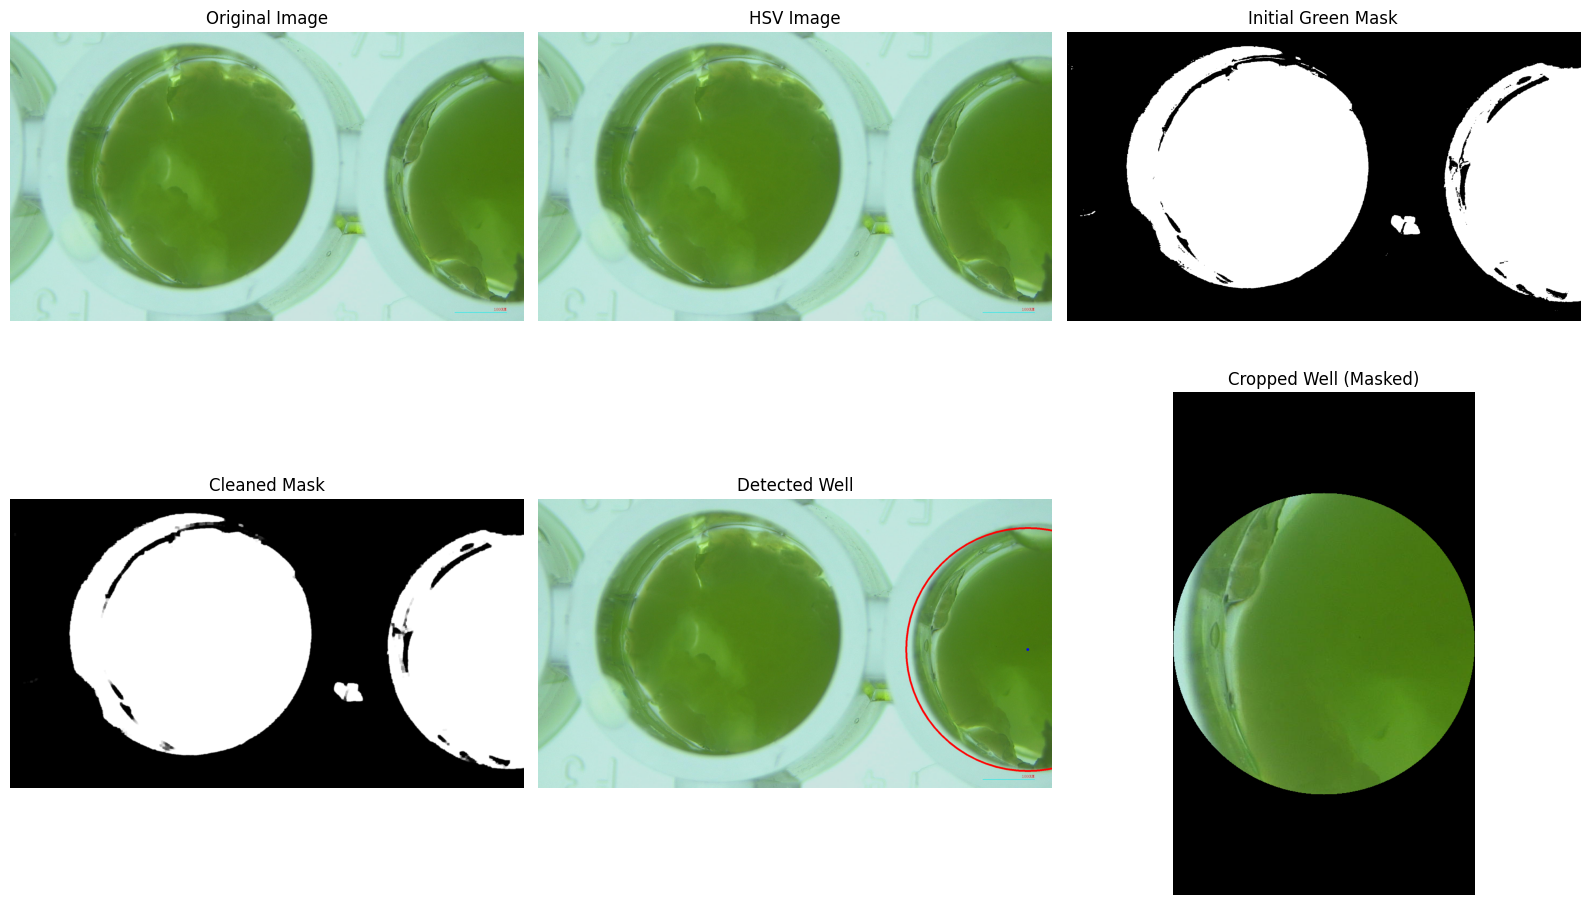

In [82]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Path to your image
image_path = "New MLPR Data/48 hr/pH6 Hydrolytic/48hr_pH6_W3.JPG" 

# Define green color range in HSV
# lower_green = np.array([20, 20, 100])
# upper_green = np.array([40, 255, 255])

lower_green = np.array([35, 90, 80])
upper_green = np.array([75, 255, 255])

# lower_green = np.array([35, 30, 50])
# upper_green = np.array([85, 150, 180])

# Load the image
image = cv2.imread(image_path)
if image is None:
    print(f"❌ Error loading image: {image_path}")
    exit()

# Convert to HSV and apply mask
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
initial_mask = cv2.inRange(hsv, lower_green, upper_green)

# Apply Gaussian Blur to smooth edges
blurred_mask = cv2.GaussianBlur(initial_mask, (5, 5), 0)

# Morphological operations to clean up the mask
kernel = np.ones((7, 7), np.uint8)
clean_mask = cv2.morphologyEx(blurred_mask, cv2.MORPH_CLOSE, kernel)
clean_mask = cv2.morphologyEx(clean_mask, cv2.MORPH_OPEN, kernel)

# Find contours
contours, _ = cv2.findContours(clean_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
well_contour = None
max_radius = 0

# Identify the largest reasonably circular contour
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area < 5000:
        continue

    (x, y), radius = cv2.minEnclosingCircle(cnt)
    circularity = (4 * np.pi * area) / (cv2.arcLength(cnt, True) ** 2 + 1e-5)
    
    if radius > max_radius and radius > 30 and circularity > 0.6:
        max_radius = radius
        well_contour = (int(x), int(y), int(radius))

# Draw and crop the well
output = image.copy()
cropped_result = None

if well_contour:
    x, y, r = well_contour
    cv2.circle(output, (x, y), r, (0, 0, 255), 5)
    cv2.circle(output, (x, y), 5, (255, 0, 0), -1)

    h, w = image.shape[:2]
    x1, y1 = max(x - r, 0), max(y - r, 0)
    x2, y2 = min(x + r, w), min(y + r, h)

    cropped_image = image[y1:y2, x1:x2]
    
    if cropped_image.size > 0:
        h_c, w_c = cropped_image.shape[:2]
        circular_mask = np.zeros((h_c, w_c), dtype=np.uint8)
        cv2.circle(circular_mask, (w_c // 2, h_c // 2), min(r, w_c // 2, h_c // 2), 255, -1)
        cropped_result = cv2.bitwise_and(cropped_image, cropped_image, mask=circular_mask)

# Convert images to RGB for matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
output_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
hsv_rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
if cropped_result is not None:
    cropped_rgb = cv2.cvtColor(cropped_result, cv2.COLOR_BGR2RGB)

# Save the cropped result if it exists
if cropped_result is not None:
    save_path = "cropped_well.jpg"  
    cv2.imwrite(save_path, cropped_result)
    print(f"✅ Cropped image saved to: {save_path}")
else:
    print("❌ No cropped result to save.")


# Plot the results
plt.figure(figsize=(16, 10))

plt.subplot(2, 3, 1)
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(hsv_rgb)
plt.title("HSV Image")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(initial_mask, cmap='gray')
plt.title("Initial Green Mask")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(clean_mask, cmap='gray')
plt.title("Cleaned Mask")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(output_rgb)
plt.title("Detected Well")
plt.axis('off')

if cropped_result is not None:
    plt.subplot(2, 3, 6)
    plt.imshow(cropped_rgb)
    plt.title("Cropped Well (Masked)")
    plt.axis('off')

plt.tight_layout()
plt.show()


❌ No cropped result to save.


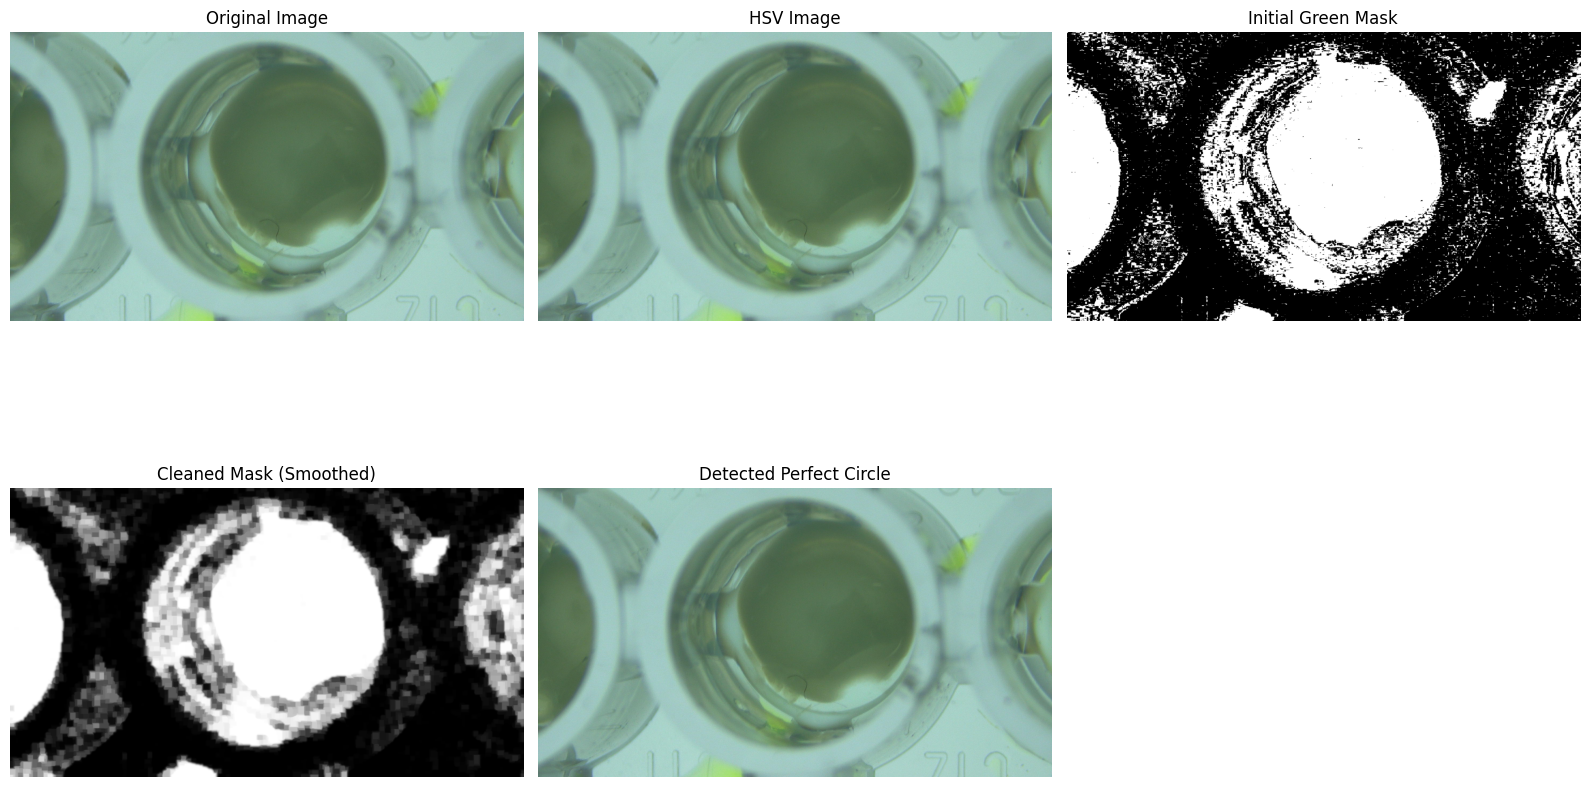

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Path to your image
image_path = "New MLPR Data/264 hr/pH7 Hydrolytic/264hr_pH7_W23.JPG"

# Define green color range in HSV
# lower_green = np.array([35, 90, 80])
# upper_green = np.array([75, 255, 255])

# lower_green = np.array([20, 20, 100])
# upper_green = np.array([60, 255, 255])

# lower_green = np.array([35, 50, 70])
# upper_green = np.array([75, 210, 230])

# lower_green = np.array([35, 20, 60])
# upper_green = np.array([85, 120, 180])

lower_well_structure = np.array([10, 10, 200])
upper_well_structure = np.array([180, 50, 255])


# Load the image
image = cv2.imread(image_path)
if image is None:
    print(f"❌ Error loading image: {image_path}")
    exit()

# Convert to HSV and apply mask
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
initial_mask = cv2.inRange(hsv, lower_green, upper_green)

# Stronger smoothing
blurred_mask = cv2.GaussianBlur(initial_mask, (21, 21), 0)

# Stronger morphological operations
kernel = np.ones((15, 15), np.uint8)
clean_mask = cv2.morphologyEx(blurred_mask, cv2.MORPH_CLOSE, kernel)
clean_mask = cv2.morphologyEx(clean_mask, cv2.MORPH_OPEN, kernel)

# Find contours on the cleaned mask
contours, _ = cv2.findContours(clean_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the left-most valid contour
well_contour = None
min_x = float('inf')

for cnt in contours:
    area = cv2.contourArea(cnt)
    if area < 5000:
        continue
    (x, y), radius = cv2.minEnclosingCircle(cnt)
    circularity = (4 * np.pi * area) / (cv2.arcLength(cnt, True) ** 2 + 1e-5)
    if radius > 100 and circularity > 0.6:
        if x < min_x:
            min_x = x
            well_contour = (int(x), int(y), int(radius))

output = image.copy()
cropped_result = None

if well_contour:
    x, y, r = well_contour
    # Draw perfect circle
    cv2.circle(output, (x, y), r, (0, 0, 255), 5)
    cv2.circle(output, (x, y), 5, (255, 0, 0), -1)

    # Create a perfect circle mask
    perfect_circle_mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.circle(perfect_circle_mask, (x, y), r, 255, -1)

    # Apply the perfect mask to the original image
    masked_image = cv2.bitwise_and(image, image, mask=perfect_circle_mask)

    # Crop the bounding box around the circle
    h, w = image.shape[:2]
    x1, y1 = max(x - r, 0), max(y - r, 0)
    x2, y2 = min(x + r, w), min(y + r, h)
    cropped_result = masked_image[y1:y2, x1:x2]

# Convert images to RGB for matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
output_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
hsv_rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
if cropped_result is not None:
    cropped_rgb = cv2.cvtColor(cropped_result, cv2.COLOR_BGR2RGB)

# Save the cropped result if it exists
if cropped_result is not None:
    save_path = "cropped_perfect_circle.JPG"
    cv2.imwrite(save_path, cropped_result)
    print(f"✅ Cropped image saved to: {save_path}")
else:
    print("❌ No cropped result to save.")

# Plot the results
plt.figure(figsize=(16, 10))

plt.subplot(2, 3, 1)
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(hsv_rgb)
plt.title("HSV Image")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(initial_mask, cmap='gray')
plt.title("Initial Green Mask")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(clean_mask, cmap='gray')
plt.title("Cleaned Mask (Smoothed)")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(output_rgb)
plt.title("Detected Perfect Circle")
plt.axis('off')

if cropped_result is not None:
    plt.subplot(2, 3, 6)
    plt.imshow(cropped_rgb)
    plt.title("Cropped Perfect Circle")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# ✅ Set your target folder (change this to any specific folder like "pH6 Hydrolytic")
target_folder = "New MLPR Data/264 hr/pH7 Hydrolytic"

# Define green color range in HSV
# lower_green = np.array([20, 20, 100])
# upper_green = np.array([40, 255, 255])

# lower_green = np.array([35, 60, 60])
# upper_green = np.array([85, 255, 255])

# # Claude for pH 5-6
# lower_green = np.array([40, 30, 100])
# upper_green = np.array([80, 200, 255])

# ## Calude for pH 7-8
# lower_green = np.array([40, 30, 40])
# upper_green = np.array([80, 255, 255])


# Function to process and save a single image
def process_image(image_path, save_base_dir, relative_subpath=""):
    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ Error loading image: {image_path}")
        return

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    initial_mask = cv2.inRange(hsv, lower_green, upper_green)
    blurred_mask = cv2.GaussianBlur(initial_mask, (21, 21), 0)
    kernel = np.ones((15, 15), np.uint8)
    clean_mask = cv2.morphologyEx(blurred_mask, cv2.MORPH_CLOSE, kernel)
    clean_mask = cv2.morphologyEx(clean_mask, cv2.MORPH_OPEN, kernel)

    contours, _ = cv2.findContours(clean_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    well_contour = None
    min_x = float('inf')
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 5000:
            continue
        (x, y), radius = cv2.minEnclosingCircle(cnt)
        circularity = (4 * np.pi * area) / (cv2.arcLength(cnt, True) ** 2 + 1e-5)
        if radius > 30 and circularity > 0.6:
            if x < min_x:
                min_x = x
                well_contour = (int(x), int(y), int(radius))

    if well_contour:
        x, y, r = well_contour
        perfect_circle_mask = np.zeros(image.shape[:2], dtype=np.uint8)
        cv2.circle(perfect_circle_mask, (x, y), r, 255, -1)
        masked_image = cv2.bitwise_and(image, image, mask=perfect_circle_mask)
        h, w = image.shape[:2]
        x1, y1 = max(x - r, 0), max(y - r, 0)
        x2, y2 = min(x + r, w), min(y + r, h)
        cropped_result = masked_image[y1:y2, x1:x2]

        filename = os.path.basename(image_path)
        cropped_name = f"cropped_{filename}"
        save_path = os.path.join(save_base_dir, relative_subpath, cropped_name)
        
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        cv2.imwrite(save_path, cropped_result)
        print(f"✅ Saved: {save_path}")
    else:
        print(f"⚠️ No valid contour found in {image_path}")

# ✅ Set where cropped images should be saved
save_base_dir = "Processed_Cropped_Images"

# Loop through only JPGs in the selected folder
for file in os.listdir(target_folder):
    if file.endswith(".JPG"):
        img_path = os.path.join(target_folder, file)
        process_image(img_path, save_base_dir, relative_subpath=os.path.relpath(target_folder, "New MLPR Data"))


Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


⚠️ No valid contour found in New MLPR Data/264 hr/pH7 Hydrolytic/264hr_pH7_W5.JPG
⚠️ No valid contour found in New MLPR Data/264 hr/pH7 Hydrolytic/264hr_pH7_W16.JPG
⚠️ No valid contour found in New MLPR Data/264 hr/pH7 Hydrolytic/264hr_pH7_W17.JPG
⚠️ No valid contour found in New MLPR Data/264 hr/pH7 Hydrolytic/264hr_pH7_W4.JPG
⚠️ No valid contour found in New MLPR Data/264 hr/pH7 Hydrolytic/264hr_pH7_W6.JPG
⚠️ No valid contour found in New MLPR Data/264 hr/pH7 Hydrolytic/264hr_pH7_W29.JPG
⚠️ No valid contour found in New MLPR Data/264 hr/pH7 Hydrolytic/264hr_pH7_W15.JPG
⚠️ No valid contour found in New MLPR Data/264 hr/pH7 Hydrolytic/264hr_pH7_W14.JPG
⚠️ No valid contour found in New MLPR Data/264 hr/pH7 Hydrolytic/264hr_pH7_W28.JPG
⚠️ No valid contour found in New MLPR Data/264 hr/pH7 Hydrolytic/264hr_pH7_W7.JPG
✅ Saved: Processed_Cropped_Images/264 hr/pH7 Hydrolytic/cropped_264hr_pH7_W3.JPG
⚠️ No valid contour found in New MLPR Data/264 hr/pH7 Hydrolytic/264hr_pH7_W10.JPG


Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


⚠️ No valid contour found in New MLPR Data/264 hr/pH7 Hydrolytic/264hr_pH7_W38.JPG
⚠️ No valid contour found in New MLPR Data/264 hr/pH7 Hydrolytic/264hr_pH7_W39.JPG
⚠️ No valid contour found in New MLPR Data/264 hr/pH7 Hydrolytic/264hr_pH7_W11.JPG
⚠️ No valid contour found in New MLPR Data/264 hr/pH7 Hydrolytic/264hr_pH7_W2.JPG
⚠️ No valid contour found in New MLPR Data/264 hr/pH7 Hydrolytic/264hr_pH7_W13.JPG
⚠️ No valid contour found in New MLPR Data/264 hr/pH7 Hydrolytic/264hr_pH7_W12.JPG
⚠️ No valid contour found in New MLPR Data/264 hr/pH7 Hydrolytic/264hr_pH7_W1.JPG
⚠️ No valid contour found in New MLPR Data/264 hr/pH7 Hydrolytic/264hr_pH7_W48.JPG
⚠️ No valid contour found in New MLPR Data/264 hr/pH7 Hydrolytic/264hr_pH7_W40.JPG
✅ Saved: Processed_Cropped_Images/264 hr/pH7 Hydrolytic/cropped_264hr_pH7_W41.JPG
⚠️ No valid contour found in New MLPR Data/264 hr/pH7 Hydrolytic/264hr_pH7_W43.JPG
⚠️ No valid contour found in New MLPR Data/264 hr/pH7 Hydrolytic/264hr_pH7_W42.JPG
⚠️ No v

Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


⚠️ No valid contour found in New MLPR Data/264 hr/pH7 Hydrolytic/264hr_pH7_W24.JPG
⚠️ No valid contour found in New MLPR Data/264 hr/pH7 Hydrolytic/264hr_pH7_W9.JPG
⚠️ No valid contour found in New MLPR Data/264 hr/pH7 Hydrolytic/264hr_pH7_W32.JPG
⚠️ No valid contour found in New MLPR Data/264 hr/pH7 Hydrolytic/264hr_pH7_W26.JPG
⚠️ No valid contour found in New MLPR Data/264 hr/pH7 Hydrolytic/264hr_pH7_W27.JPG
✅ Saved: Processed_Cropped_Images/264 hr/pH7 Hydrolytic/cropped_264hr_pH7_W33.JPG
⚠️ No valid contour found in New MLPR Data/264 hr/pH7 Hydrolytic/264hr_pH7_W8.JPG
